# General variables and libraries
Run this cell first

In [1]:
import os
import cld4py
import numpy as np
import pandas as pd
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
import colorcet as cc
import matplotlib.patches as mpatches
from patsy import ModelDesc
from statsmodels.formula.api import ols
from matplotlib.ticker import FormatStrFormatter

%matplotlib inline

sns.set_style("ticks")
plt.rcParams['axes.linewidth'] = .5
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.facecolor'] = 'w'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

!mkdir -p Results Figures

# Install dependencies

In [1]:
!pip install colorcet
!pip install cld4py --upgrade
!qiime dev refresh-cache

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 260.3/260.3 kB 8.4 MB/s eta 0:00:00
QIIME is caching your current deployment for improved performance. This may take a few moments and should only happen once per deployment.


# 16S rRNAs from Standard

In [2]:
FWD = 'AGAGTTTGATCMTGGCTCAG'
RVS = 'CGGTTACCTTGTTACGACTT'
GTDB_db = '/home/ty/Big_data/NaMeco_Minion/GTDB_test'
outdir = 'Results/16S'

## Extracted / Present ratios

### GTDB

In [5]:
#download

!mkdir -p {GTDB_db}
!qiime rescript get-gtdb-data \
    --p-db-type 'All' \
    --o-gtdb-taxonomy {GTDB_db}/gtdb-taxa.qza \
    --o-gtdb-sequences {GTDB_db}/gtdb-seqs.qza

Saved FeatureData[Taxonomy] to: /home/ty/Big_data/NaMeco_Minion/GTDB_test/gtdb-taxa.qza
Saved FeatureData[Sequence] to: /home/ty/Big_data/NaMeco_Minion/GTDB_test/gtdb-seqs.qza


In [18]:
#extract reads

!qiime feature-classifier extract-reads \
    --i-sequences {GTDB_db}/gtdb-seqs.qza \
    --p-f-primer {FWD} \
    --p-r-primer {RVS} \
    --p-read-orientation 'both' \
    --p-identity .95 \
    --o-reads {GTDB_db}/gtdb-seqs-extr.qza \
    --p-n-jobs 16 

Saved FeatureData[Sequence] to: /home/ty/Big_data/NaMeco_Minion/GTDB_test/gtdb-seqs-extr.qza


In [19]:
# extract sequences

!qiime tools export \
    --input-path {GTDB_db}/gtdb-seqs.qza \
    --output-path Data/GTDB-orig

!qiime tools export \
    --input-path {GTDB_db}/gtdb-seqs-extr.qza \
    --output-path Data/GTDB-extr

Exported /home/ty/Big_data/NaMeco_Minion/GTDB_test/gtdb-seqs-extr.qza as DNASequencesDirectoryFormat to directory Data/GTDB-extr


In [20]:
!mkdir -p {outdir}/Counts
for file in ['orig', 'extr']:
    
    !mv Data/GTDB-{file}/dna-sequences.fasta {outdir}/Counts/GTDB-{file}.fasta
    !rm -r Data/GTDB-{file}

mv: cannot stat 'Data/GTDB-orig/dna-sequences.fasta': No such file or directory
rm: cannot remove 'Data/GTDB-orig': No such file or directory


### 16S Standards

In [15]:
for std in ['Zymo_Com', 'Zymo_Gut']:

    #import to qiime2
    !cp Data/{std}/ssu_RNAs/All.fasta {outdir}/Counts/16S_{std}-orig.fasta
    !qiime tools import \
        --type 'FeatureData[Sequence]' \
        --input-path Data/{std}/ssu_RNAs/All.fasta \
        --output-path {outdir}/Counts/16S_{std}.qza
    
    #extract reads
    !qiime feature-classifier extract-reads \
        --i-sequences {outdir}/Counts/16S_{std}.qza \
        --p-f-primer {FWD} \
        --p-r-primer {RVS} \
        --p-read-orientation 'both' \
        --p-identity .95 \
        --o-reads {outdir}/Counts/16S_{std}-extr.qza \
        --p-n-jobs 16 

    # extract sequences
    !qiime tools export \
        --input-path {outdir}/Counts/16S_{std}-extr.qza \
        --output-path {outdir}/Counts/{std}-extr

    !mv {outdir}/Counts/{std}-extr/dna-sequences.fasta {outdir}/Counts/16S_{std}-extr.fasta
    !rm -r {outdir}/Counts/{std}-extr

Saved FeatureData[Sequence] to: Results/16S/Counts/16S_Zymo_Com-extr.qza
Exported Results/16S/Counts/16S_Zymo_Com-extr.qza as DNASequencesDirectoryFormat to directory Results/16S/Counts/Zymo_Com-extr
Saved FeatureData[Sequence] to: Results/16S/Counts/16S_Zymo_Gut-extr.qza
Exported Results/16S/Counts/16S_Zymo_Gut-extr.qza as DNASequencesDirectoryFormat to directory Results/16S/Counts/Zymo_Gut-extr


### Extracted/Present ratios

In [80]:
SPECIES = {
    'Bacillus spizizenii': 'Bacillus subtilis',
    'Staphylococcus aureus': 'Staphylococcus aureus',
    'Listeria monocytogenes': 'Listeria monocytogenes',
    'Pseudomonas aeruginosa': 'Pseudomonas aeruginosa',
    'Limosilactobacillus fermentum': 'Lactobacillus fermentum',
    'Salmonella enterica': 'Salmonella enterica',
    'Escherichia coli': 'Escherichia coli',
    'Enterococcus faecalis': 'Enterococcus faecalis',
    'Faecalibacterium prausnitzii': 'Faecalibacterium prausnitzii',
    'Veillonella rogosae': 'Veillonella rogosae',
    'Bacteroides fragilis': 'Bacteroides fragilis',
    'Roseburia hominis': 'Roseburia hominis',
    'Bifidobacterium adolescentis': 'Bifidobacterium adolescentis',
    'Fusobacterium animalis*': 'Fusobacterium nucleatum',
    'Prevotella corporis': 'Prevotella corporis',
    'Clostridioides difficile': 'Clostridioides difficille',
    'Akkermansia muciniphila': 'Akkermansia muciniphila',
    'Clostridium perfringens': 'Clostridium perfringens',
}

summ = pd.DataFrame(index=SPECIES.keys())
    
for file in ['orig', 'extr']:
    summ[f'GTDB-{file}'] = 0
    for std in ['Zymo_Com', 'Zymo_Gut']:
         summ[f'{std}-{file}'] = 0
    with open(f'{outdir}/Counts/GTDB-{file}.fasta', 'r') as DB:
        DB = DB.read()
        summ[f'GTDB-{file}'] = 0
        for v,k in SPECIES.items():
            summ.loc[v, f'GTDB-{file}'] += DB.count(f"s__{v.strip(' *')}"\
                                           .replace('Clostridium', 'Sarcina'))
            for std in ['Zymo_Com', 'Zymo_Gut']:
                with open(f'{outdir}/Counts/16S_{std}-{file}.fasta', 'r') as STD:
                    STD = STD.read()
                    summ.loc[v, f'{std}-{file}'] += STD.count(k.replace(' ', '_'))
                    
summ.to_csv(f"{outdir}/Counts/counts.tsv", sep='\t', )    
summ

,GTDB-orig,Zymo_Com-orig,Zymo_Gut-orig,GTDB-extr,Zymo_Com-extr,Zymo_Gut-extr
Bacillus spizizenii,171,10,0,130,10,0
Staphylococcus aureus,41783,6,0,29041,6,0
Listeria monocytogenes,8679,6,0,6229,6,0
Pseudomonas aeruginosa,13370,4,0,11542,0,0
Limosilactobacillus fermentum,613,5,5,411,5,5
Salmonella enterica,37286,6,7,23793,6,7
Escherichia coli,102621,7,35,60242,7,35
Enterococcus faecalis,5425,4,4,4302,4,4
Faecalibacterium prausnitzii,293,0,6,223,0,6
Veillonella rogosae,34,0,4,15,0,4


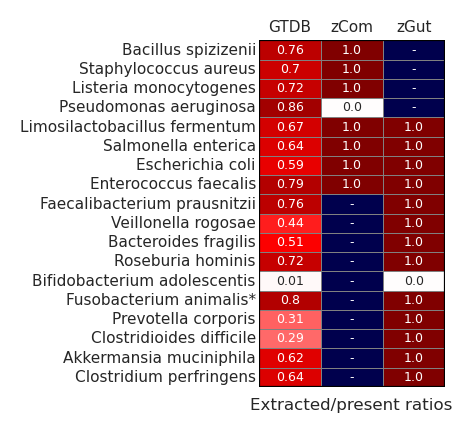

In [9]:
#plot 
summ = pd.read_csv(f"{outdir}/Counts/counts.tsv", sep='\t', index_col=0)
summ['GTDB'] = round(summ['GTDB-extr']/summ['GTDB-orig'], 2)
summ['zCom'] = round(summ['Zymo_Com-extr']/summ['Zymo_Com-orig'], 2)
summ['zGut'] = round(summ['Zymo_Gut-extr']/summ['Zymo_Gut-orig'], 2)
summ = summ[['GTDB', 'zCom', 'zGut']]
annot = summ[['GTDB', 'zCom', 'zGut']].fillna('-')


S = 8
H = len(summ)/S #height of figure
step = 1/(H*S) #height of 1 line
vmax = summ.max().max()
summ = summ[['GTDB', 'zCom', 'zGut']].fillna(-vmax)
vmin = summ.min().min()

#figure
fig, ax = plt.subplots(1, 1, figsize=(1.2, H))

sns.heatmap(data=summ, ax=ax, cbar_kws={'orientation':'horizontal'}, annot=annot, cbar=False,
            square=False, center=0, cmap='seismic', xticklabels=True, yticklabels=True,
            annot_kws={"size":4.5,}, linewidths=.2, linecolor='grey', fmt = '')

#aesthetics
ax.set_xlabel('Extracted/present ratios', fontsize=6)
ax.set_ylabel('')
ax.tick_params(axis='both', labelsize=5.5, length=0, pad=1)
ax.tick_params(axis='x',  pad=2, )
ax.xaxis.tick_top()

#lines around axes
ax.axhline(y=0, color='k',linewidth=.8)
ax.axhline(y=len(summ), color='k',linewidth=.8)
ax.axvline(x=0, color='k',linewidth=.8)
ax.axvline(x=len(summ.columns), color='k',linewidth=.8)

plt.savefig(f'Figures/Extracted_ratios.svg')

# Hosts

In [18]:
import os
import numpy as np
import pandas as pd
from scipy import stats
from itertools import combinations
from statsmodels.stats.multitest import multipletests
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import statsmodels.api as sm
#from statannot import add_stat_annotation
import colorcet as cc
import matplotlib.patches as mpatches
from patsy import ModelDesc
from statsmodels.formula.api import ols

%matplotlib inline

sns.set_style("ticks")
plt.rcParams['axes.linewidth'] = .5
plt.rcParams['figure.dpi'] = 200
plt.rcParams['savefig.dpi'] = 500
plt.rcParams['savefig.bbox'] = 'tight'
plt.rcParams['savefig.facecolor'] = 'w'
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

#VARIABLES
OUT = 'Results/Hosts'
META = pd.read_csv('metadata.tsv', sep='\t', index_col=0)
TAXA = f'{OUT}/GTDB-taxonomy.qza'
TREE = f'{OUT}/rooted_tree.qza'
TABLE = f'{OUT}/table.qza'
COREM = f'{OUT}/Results/Core-metrics'
REPSEQS = f'{OUT}/rep-seqs.qza'

ALPHAS = {
    'shannon': 'Shannon entropy',
    'faith_pd': 'Faith\'s PD',
}

MDICT = {
    'Human': 'H',
    'Pig': 'P',
    'Chicken': 'v',
}

!mkdir -p Results Figures

In [60]:
#import feature table
!biom convert \
    -i {OUT}/cluster_counts.tsv \
    -o table.biom \
    --table-type="OTU table" \
    --to-hdf5

!qiime tools import \
    --input-path table.biom \
    --type 'FeatureTable[Frequency]' \
    --input-format BIOMV210Format \
    --output-path $TABLE

!rm table.biom

#import taxonomy
!qiime tools import \
    --type 'FeatureData[Taxonomy]' \
    --input-path {OUT}/Taxonomy-q2.tsv \
    --output-path {TAXA}

#import representative sequences
!qiime tools import \
    --type 'FeatureData[Sequence]' \
    --input-path {OUT}/rep_seqs.fasta \
    --output-path {REPSEQS}

Imported table.biom as BIOMV210Format to Results/Hosts/table.qza
Imported Results/Hosts/Taxonomy-q2.tsv as TSVTaxonomyDirectoryFormat to Results/Hosts/GTDB-taxonomy.qza
Imported Results/Hosts/rep_seqs.fasta as DNASequencesDirectoryFormat to Results/Hosts/rep-seqs.qza


## Filtering to remove unwanted features

In [61]:
tabv = TABLE.replace('qza', 'qzv')

#by domain
!qiime taxa filter-table \
    --i-table $TABLE \
    --i-taxonomy $TAXA \
    --p-include d__Bacteria \
    --o-filtered-table $TABLE

#remove organelles
!qiime taxa filter-table \
    --i-table $TABLE \
    --i-taxonomy $TAXA \
    --p-exclude mitochondria,chloroplast \
    --o-filtered-table $TABLE

#remove features, not annotated to the phylum level 
!qiime taxa filter-table \
    --i-table $TABLE \
    --i-taxonomy $TAXA \
    --p-include p__ \
    --o-filtered-table $TABLE

#samples by features depth
!qiime feature-table filter-samples \
    --i-table $TABLE \
    --p-min-frequency 5000 \
    --o-filtered-table $TABLE

#summarize
!qiime feature-table summarize \
    --i-table $TABLE \
    --m-sample-metadata-file metadata.tsv \
    --o-visualization $tabv

#repseqs by feature table
!qiime feature-table filter-seqs \
    --i-data $REPSEQS \
    --i-table $TABLE \
    --o-filtered-data $REPSEQS

Saved FeatureTable[Frequency] to: Results/Hosts/table.qza
Saved FeatureTable[Frequency] to: Results/Hosts/table.qza
Saved FeatureTable[Frequency] to: Results/Hosts/table.qza
Saved FeatureTable[Frequency] to: Results/Hosts/table.qza
Saved Visualization to: Results/Hosts/table.qzv
Saved FeatureData[Sequence] to: Results/Hosts/rep-seqs.qza


## Plant a tree

In [62]:
!qiime phylogeny align-to-tree-mafft-fasttree \
    --i-sequences $REPSEQS \
    --p-n-threads 4 \
    --o-alignment Data/aligned.qza \
    --o-masked-alignment Data/masked.qza \
    --o-tree Data/unrooted.qza \
    --o-rooted-tree $TREE

!rm Data/aligned.qza Data/masked.qza Data/unrooted.qza

Saved FeatureData[AlignedSequence] to: Data/aligned.qza
Saved FeatureData[AlignedSequence] to: Data/masked.qza
Saved Phylogeny[Unrooted] to: Data/unrooted.qza
Saved Phylogeny[Rooted] to: Results/Hosts/rooted_tree.qza


## Core-metrics

In [63]:
!qiime diversity core-metrics-phylogenetic \
    --i-table $TABLE \
    --i-phylogeny $TREE \
    --p-sampling-depth 80000 \
    --m-metadata-file metadata.tsv \
    --p-n-jobs-or-threads 'auto' \
    --output-dir $COREM

Saved FeatureTable[Frequency] to: Results/Hosts/Results/Core-metrics/rarefied_table.qza
Saved SampleData[AlphaDiversity] to: Results/Hosts/Results/Core-metrics/faith_pd_vector.qza
Saved SampleData[AlphaDiversity] to: Results/Hosts/Results/Core-metrics/observed_features_vector.qza
Saved SampleData[AlphaDiversity] to: Results/Hosts/Results/Core-metrics/shannon_vector.qza
Saved SampleData[AlphaDiversity] to: Results/Hosts/Results/Core-metrics/evenness_vector.qza
Saved DistanceMatrix to: Results/Hosts/Results/Core-metrics/unweighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: Results/Hosts/Results/Core-metrics/weighted_unifrac_distance_matrix.qza
Saved DistanceMatrix to: Results/Hosts/Results/Core-metrics/jaccard_distance_matrix.qza
Saved DistanceMatrix to: Results/Hosts/Results/Core-metrics/bray_curtis_distance_matrix.qza
Saved PCoAResults to: Results/Hosts/Results/Core-metrics/unweighted_unifrac_pcoa_results.qza
Saved PCoAResults to: Results/Hosts/Results/Core-metrics/weighted_u

In [64]:
#function to unzip matrix
def get_matrix(qza):
    a = !unzip $qza
    out = a[1].split('/')[0].replace('  inflating: ','')
    inf = out + '/data/distance-matrix.tsv'
    matrix = pd.read_csv(inf,index_col=0,sep='\t')
    !rm -rf $out
    return matrix

# Unzipping qza pcoa
def parse_pcoa(qza): 
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ', '')
    inf = digest + '/data/ordination.txt'
    lines = open(inf, 'r').readlines()
    Eigvals = [float(i) for i in lines[1].rstrip().split('\t')]
    Proportion = [float(i) for i in lines[4].rstrip().split('\t')]
    pca_skipr = len(open(inf,'r').read().split('Site')[0].splitlines()) + 1
    pcoa = pd.read_csv(inf, index_col=0, skiprows=pca_skipr, skipfooter=4,\
                       header=None, sep='\t', engine='python')
    !rm -r $digest
    return  pcoa, Proportion

## PCoA plots

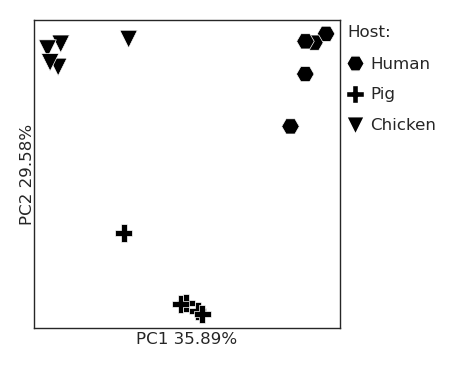

In [65]:
#plot pcoa

x, y = 1, 2 # axes to plot

fig, axes = plt.subplots(1, 2, figsize=(2.2, 2), 
                         gridspec_kw={'wspace': .12, 'width_ratios': [2, .1]})

ordin, Prop = parse_pcoa(f'{COREM}/bray_curtis_pcoa_results.qza')
ordin[['Host']] = META[['Host']]
#pca_meta = META.loc[META.index.isin(ordin.index)].copy()
ax = axes[0]
plot = sns.scatterplot(x=x, y=y, data=ordin, ax=ax, linewidth=0.25, legend=False,
                      style='Host', markers=MDICT, s=40, c='black')

ax.set_xticks([])
ax.set_yticks([])
ax.set_ylabel(f'PC{y:d} {Prop[y-1]*100:.2f}%', fontsize=6, labelpad=-4)
ax.set_xlabel(f'PC{x:d} {Prop[x-1]*100:.2f}%', fontsize=6, labelpad=-2)
    
# legend
ax = axes[-1]
ax.axis('off')
ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
yax, xax = .96, -.3
ystep, xstep = .1, 1
fsize = 6

#ax.text(xax-.5, yax -.012, 'phyRPCA', fontsize=fsize)

#yax -= ystep*1.5
ax.text(xax-.5, yax -.015, 'Host:', fontsize=fsize)
for k,v in MDICT.items():
    yax -= ystep
    sns.scatterplot(x=[xax], y=[yax], ax=ax, s=40, clip_on=False, c='black', marker=v)
    ax.text(xax + 1, yax -.018, k, fontsize=fsize)

plt.savefig(f'Figures/PCoA_BC_hosts.svg')

## Alpha Plot

### Add alpha metrics to metadata file

In [19]:
def add_alpha(qza):  
    a = !unzip $qza
    out = a[1].split('/')[0].replace('  inflating: ', '')
    inf = f'{out}/data/alpha-diversity.tsv'
    df = pd.read_csv(inf, sep='\t', index_col=0)
    !rm -rf $out
    return df 

for alpha in ALPHAS:
    data = add_alpha(f'{COREM}/{alpha}_vector.qza')
    META.loc[META.index.isin(data.index), alpha] = data.iloc[:, 0]
display(META)
META.to_csv('metadata.tsv', sep='\t')

,Host,sType,BarcodeID,shannon,faith_pd
SampleID,,,,,
508P,Pig,feces,barcode01,4.484421,21.271423
497P,Pig,feces,barcode02,5.277795,19.416699
502P,Pig,feces,barcode03,5.327936,20.637144
506P,Pig,feces,barcode04,5.844102,22.015554
503P,Pig,feces,barcode05,4.687748,19.388273
S19H,Human,feces,barcode06,5.691801,15.928272
S20H,Human,feces,barcode07,4.273047,9.243352
S21H,Human,feces,barcode08,3.817297,7.801121
S22H,Human,feces,barcode09,3.599974,9.232720


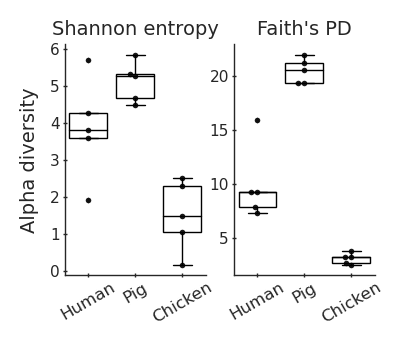

In [23]:
rows = 1
cols = 2
alphas = ['shannon', 'faith_pd']


#set figure
fig, axes = plt.subplots(rows, cols, figsize=(2, 1.5), sharex='col',
            gridspec_kw={'wspace': .2, 'hspace': .1})
#axs, i = [[r, c] for r in range(rows) for c in range(cols)], 0

for i, alpha in enumerate(alphas):
    data = META[(META[alpha].notna())].copy()
    
    ### Boxplots ###
    ax = axes[i]
    
    sns.boxplot(x='Host', y=alpha, data=data, ax=ax, linewidth=0.4, fliersize=0.3, 
                order=MDICT, color='white', showfliers=True)
    sns.swarmplot(x='Host', y=alpha, data=data, order=MDICT, ax=ax, size=2,
                  c='black', alpha=0.9, legend=False)
    ax.tick_params(axis='both', labelsize=5.5, length=1.5, pad=1, width=0.5, direction='inout')
    ax.tick_params(axis='x', labelsize=6, rotation=30)

    ax.set_ylabel('')
    ax.set_xlabel('')
    if alpha == alphas[0]:
        ax.set_ylabel('Alpha diversity', fontsize=7, )

    ax.text(.5, 1.04, ALPHAS[alpha], ha='center', fontsize=7, transform=ax.transAxes)
    
    #line color/width
    for patch in ax.patches:
        patch.set_edgecolor('black')
        patch.set_linewidth(.5)
    plt.setp(ax.lines, color='k', lw=.5)
    ax.spines[['right', 'top']].set_visible(False)

  
fig.align_labels()
#fig.suptitle(ALPHAS[alpha], fontsize=7, y=.97)
plt.savefig(f'Figures/Alpha_Hosts.svg')

## Percent Identity Plot

In [68]:
counts = pd.read_csv(f'{OUT}/cluster_counts.tsv', sep='\t', index_col=0)
taxons = pd.read_csv(f'{OUT}/Taxonomy.tsv', sep='\t', index_col=0)

dfs = []
for host in MDICT:
    count = counts[[c for c in counts.columns if c.endswith(host[0].upper())]].copy()
    count = count.loc[~(count==0).all(axis=1)]
    count['Percent identity'] = taxons['Perc. id.']
    count = count[['Percent identity']]
    count['Host'] = host
    dfs.append(count)
    
data = pd.concat(dfs)
data.to_csv(f'{OUT}/Hosts_Pind.csv')

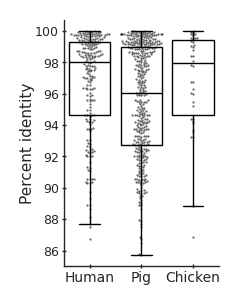

In [70]:
rows = 1
cols = 1

#set figure
fig, ax = plt.subplots(rows, cols, figsize=(1, 1.6))

#data
data = pd.read_csv(f'{OUT}/Hosts_Pind.csv')

### Boxplots ###
sns.boxplot(x='Host', y='Percent identity', data=data, ax=ax, linewidth=0.4, fliersize=0.3, 
            order=MDICT, color='white', showfliers=False, )
sns.swarmplot(x='Host', y='Percent identity', data=data, order=MDICT, ax=ax, size=.8, 
              alpha=0.6, legend=False, c='black', )
ax.tick_params(axis='both', labelsize=4.5, length=1.5, pad=1, width=0.5, direction='inout')
ax.tick_params(axis='x', labelsize=5, )
ax.set_xlabel('') 
ax.set_ylabel('Percent identity', fontsize=5.5, labelpad=0)
#ax.text(.5, 1.14, "GTDB vs NCBI", ha='center', fontsize=7, transform=ax.transAxes)

#line color/width
for patch in ax.patches:
    patch.set_edgecolor('black')
    patch.set_linewidth(.5)
plt.setp(ax.lines, color='k', lw=.5)
ax.spines[['right', 'top']].set_visible(False)

plt.savefig(f'Figures/Pind_hosts.svg')

## Taxabarplots

In [ ]:
!pip install colorcet

In [71]:
!mkdir -p Results/Taxabarplots
    
!qiime taxa barplot \
    --i-table {TABLE} \
    --i-taxonomy {TAXA} \
    --m-metadata-file metadata.tsv \
    --o-visualization Results/Taxabarplots/GTDB-taxabarplot-hosts.qzv

Saved Visualization to: Results/Taxabarplots/GTDB-taxabarplot-hosts.qzv


### Import libraries and declare variables

In [72]:
colours = cc.glasbey_hv
del colours[26] #remove white color


def bar_unzip(qza, lev):    
    a = !unzip $qza
    digest = a[1].split('/')[0].replace('  inflating: ', '')
    inf = digest + f'/data/level-{lev}.csv'
    data = pd.read_csv(inf, sep=',', index_col=0)
    !rm -rf $digest
    return data

### Taxabarplots DBs

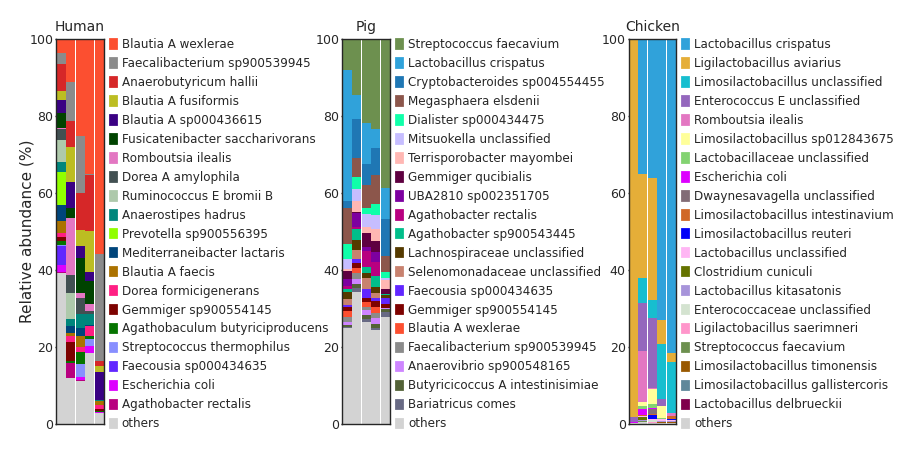

In [85]:
drep = {
    '_': ' ',
    ';': ' ',
}

top = 20
rows, cols = 1, len(MDICT)

#figure
fig, axes = plt.subplots(rows, cols, figsize=(4, 2.5), gridspec_kw={'wspace': 5})
#axs, i = [[r, c] for r in range(rows) for c in range(cols)], 0

#data
df = bar_unzip(f'Results/Taxabarplots/GTDB-taxabarplot-hosts.qzv', 7)
df = df[[col for col in df.columns if 'p__' in col]]
meta = META.loc[df.index].copy()
#df = df.groupby(level=0, axis=1).sum() #sum duplicates
df.loc['mean', :] = df.mean() #add a row with mean 
df.sort_values(inplace=True, axis=1, by='mean', ascending=True) #sort features by mean of abundances
df.drop(inplace=True, index='mean')
df = df.div(df.sum(axis=1), axis=0) * 100 #convert to % (rel ab)
for k, v in drep.items():
    df.columns = [c.replace(k, v) for c in df.columns]
df.columns = [c.strip(' ').split('  ')[-1] for c in df.columns]
df.to_csv(f'Results/Taxabarplots/GTDB-taxabarplot-hosts', sep='\t')
#display(df)

#cmap
cdict = dict(zip(df.columns.tolist()[::-1], colours))

for i, group in enumerate(MDICT):
    legend = []
    md = meta.loc[(META.Host == group)]
    data = df.loc[md.index].copy()
    data.loc['mean', :] = data.mean() #add a row with mean
    data.sort_values(inplace=True, axis=1, by='mean', ascending=True) #sort features by mean of abundances
    data.drop(inplace=True, index='mean')
    data = data[data.columns.tolist()[-top:]]
    data = data.sort_values(data.columns[-1])

    #ax, i = axes[axs[i][0]][axs[i][1]], i+1
    ax = axes[i]
    bottom = [100 - data.loc[j,:].sum() for j in data.index] #starting points for stacked barplot
    ax.bar(x=data.index, height=bottom, color='lightgrey', width=.95, linewidth=0)

    for col in data.columns: #iterate through all features
        c = cdict[col] #define color
        if col not in legend: 
            legend = [col] + legend #add color to legend
        ax.bar(x=data.index, height=data[col], bottom=bottom, color=c, label=col, width=.95, linewidth=0)
        bottom = [a + b for a, b in zip(bottom, data[col].tolist())] #update bottom 

    #aesthetics
    ax.tick_params(axis='both', labelsize=4.5, pad=.5, length=.5, width=0.5) #adjust ticks
    ax.set_xticks([])
    ax.set_ylim(0, 100) #set limit for y axis
    ax.set_xlim(-.5, len(data.index) - .5) #set limit for x axis
    ax.set_ylabel('', fontsize=6, labelpad=0)
    ax.text(.5, 1.02, group, ha='center', fontsize=5, transform=ax.transAxes)
    if group == list(MDICT.keys())[0]:
        ax.set_ylabel(f'Relative abundance (%)', fontsize=5.5, labelpad=-2)
    
    #legend
    labels = legend + ['others']                     
    handles = [mpatches.Patch(color='lightgrey', label=l) if l == 'others' \
              else mpatches.Patch(color=cdict[l], label=l) for l in labels]

    leg = ax.legend(handles, labels ,loc=2, bbox_to_anchor=(.9, 1.03), fontsize=4.3, frameon=False,
                    handletextpad=0.5, handlelength=0.5, bbox_transform=ax.transAxes)  

plt.savefig(f'Figures/Taxabarplot_hosts.svg')

# Tools

## Commands

In [ ]:
#Store commands for various tools (bash)

#NanoCLUST

""""nextflow run main.nf -resume -profile docker \
    --reads "New_standard/*.fastq.gz" \
    --db "NCBI/16S_ribosomal_RNA" \
    --outdir NanoCLUST_NCBI""""

#EPI2ME
""""nextflow run epi2me-labs/wf-16s \
    --fastq 'New_standard_sub' \
    --classifier minimap2 \
    --taxonomic_rank S \
    --threads 12 \
    --out_dir Results/WF-16S_minimap2_new_std""""

#NaMeco standrad
"""nameco \
    --inp_dir 'New_standard' \
    --threads 24 \
    --no_masking"""

#NaMeco hosts
"""./nameco \
    --inp_dir '/home/ty/Big_data/NaMeco_Minion/Hosts/' \
    --out_dir '/home/ty/Big_data/NaMeco_Minion/Hosts_out/' \
    --threads 12 """

#Emu GTDB
"""ids=({IDS})
for id in ${{ids[@]}}; do
    emu abundance New_standard/$id --threads 24 --output-dir Emu_GTDB_out --db Emu_GTDB
done"""

#Emu EmuDB
"""ids=({IDS})
for id in ${{ids[@]}}; do
    emu abundance New_standard/$id --threads 24 --output-dir Emu_out --db EmuDB
done"""

## Zymo_Com

In [22]:
TOOLS = [
    'STD',
    'Emu',
    'NaMeco',
    'NanoCLUST',
    'EPI2ME',
]

RAs = 'Results/Tools/RAs/Zymo_Com'
ACC = 'Results/Tools/Accuracy/Zymo_Com'
SAMPLES = [f"C{n}S" for n in range(1,6)]
tools = TOOLS[1:]

!mkdir -p {RAs} {ACC}

In [32]:
SAMPLES

['C1S', 'C2S', 'C3S', 'C4S', 'C5S']

### RAs

In [4]:
# Zymo_Com
df = pd.read_csv('Data/Zymo_Com/standard.tsv', sep='\t', index_col=0)
df = df.div(df.sum(axis=0), axis=1)
df = df.sort_values(by='D6306', ascending=False)
df.index = df.index.str.replace('Lacto', 'Limosilacto')\
                   .str.replace('subtilis', 'spizizenii')
df.to_csv(f'{RAs}/STD_ra.tsv', sep='\t')

In [5]:
# NaMeco
df = pd.read_csv(f'Results/Tools/Tool_outs/NaMeco_Zymo_Com/Species_counts.tsv', 
                 sep='\t', index_col=0)
df = df.div(df.sum(axis=0), axis=1)
df.index = df.index.str.replace('genes B', 'genes').str.replace('er D', 'er')
df = df.groupby(df.index).sum()
df = df.reindex(df.mean(axis=1).sort_values(ascending=False).index, axis=0)
df = df[sorted(df.columns.tolist())]
df.to_csv(f'{RAs}/NaMeco_ra.tsv', sep='\t')

In [31]:
# Emu
df = pd.DataFrame()
for s in SAMPLES:
    emu = pd.read_csv(f'Results/Tools/Tool_outs/Emu_Zymo_Com/{s}.fastq_rel-abundance.tsv', 
                     sep='\t', index_col='species')
    emu = emu[emu.index.notnull()]
    df[s] = emu['abundance']
#df = df.div(df.sum(axis=0), axis=1)
df.index = df.index.str.replace('genes_B', 'genes').str.replace('er_D', 'er')\
            .str.replace('subtilis', 'spizizenii')
df = df.groupby(df.index).sum()
df = df.reindex(df.mean(axis=1).sort_values(ascending=False).index, axis=0)
df = df[sorted(df.columns.tolist())]
df.to_csv(f'{RAs}/Emu_ra.tsv', sep='\t')

In [6]:
# Emu GTDB
df = pd.DataFrame()
for s in SAMPLES:
    emu = pd.read_csv(f'Results/Tools/Tool_outs/Emu_Zymo_Com_GTDB/{s}.fastq_rel-abundance.tsv', 
                     sep='\t', index_col='Taxon')
    emu = emu[emu.index.notnull()]
    df[s] = emu['abundance']
#df = df.div(df.sum(axis=0), axis=1)
df.index = df.index.str.replace('genes_B', 'genes').str.replace('er_D', 'er')
df = df.groupby(df.index).sum()
df = df.reindex(df.mean(axis=1).sort_values(ascending=False).index, axis=0)
df = df[sorted(df.columns.tolist())]
df.to_csv(f'{RAs}/Emu_ra_GTDB.tsv', sep='\t')

In [42]:
# NanoCLUST
df = pd.DataFrame()
for s in SAMPLES:
    nc = pd.read_csv(f'Results/Tools/Tool_outs/NanoCLUST_Zymo_Com_NCBI/rel_abundance_{s}.fastq_S.csv', 
                     sep=',', index_col=0)
    df[s] = nc.rel_abundance
    
df = df.div(df.sum(axis=0), axis=1)  
df = df.reindex(df.mean(axis=1).sort_values(ascending=False).index, axis=0)
df = df[sorted(df.columns.tolist())]
df.to_csv(f'{RAs}/NanoCLUST_ra.tsv', sep='\t')   

In [33]:
# EPI2ME
df = pd.read_csv(f'Results/Tools/Tool_outs/EPI2ME_Zymo_Com.tsv', sep='\t', index_col='Species')
df = df[SAMPLES]
df = df.div(df.sum(axis=0), axis=1)
df = df.reindex(df.mean(axis=1).sort_values(ascending=False).index, axis=0)
df.to_csv(f'{RAs}/EPI2ME_ra_unkn.tsv', sep='\t')

In [34]:
# EPI2ME (no 'Unknown')
df = pd.read_csv(f'Results/Tools/Tool_outs/EPI2ME_Zymo_Com.tsv', sep='\t', index_col='Species')
df = df[SAMPLES]
df = df.loc[df.index != 'Unknown']
df = df.div(df.sum(axis=0), axis=1)
df = df.reindex(df.mean(axis=1).sort_values(ascending=False).index, axis=0)
df.to_csv(f'{RAs}/EPI2ME_ra.tsv', sep='\t')

### Barplots

'STD'

Standard,Pseudomonas aeruginosa,Enterococcus faecalis,Escherichia coli,Salmonella enterica,Listeria monocytogenes,Staphylococcus aureus,Bacillus spizizenii,Limosilactobacillus fermentum
D6306,0.042,0.099,0.101,0.104,0.141,0.155,0.174,0.184


'Emu'

species,others,Pseudomonas aeruginosa,Enterococcus faecalis,Escherichia coli,Salmonella enterica,Listeria monocytogenes,Staphylococcus aureus,Bacillus spizizenii,Limosilactobacillus fermentum
C1S,0.011769,0.022116,0.086185,0.145696,0.163098,0.129788,0.144778,0.150641,0.145929
C2S,0.010557,0.008070,0.109405,0.100030,0.114890,0.156870,0.181678,0.187181,0.130979
C3S,0.011544,0.011833,0.101908,0.111079,0.125073,0.149642,0.169133,0.175737,0.143528
C4S,0.019208,0.009165,0.106626,0.100226,0.109876,0.165835,0.179276,0.182503,0.126579
C5S,0.011003,0.013915,0.100320,0.116235,0.130315,0.146786,0.167424,0.172510,0.141145


'NaMeco'

Species,others,Pseudomonas aeruginosa,Enterococcus faecalis,Escherichia coli,Salmonella enterica,Listeria monocytogenes,Staphylococcus hominis,Staphylococcus aureus,Bacillus spizizenii,Limosilactobacillus fermentum
C1S,0.019030,0.023194,0.087791,0.147631,0.156219,0.132233,0.010987,0.155506,0.127048,0.140361
C2S,0.018444,0.007748,0.114057,0.102647,0.107567,0.157537,0.011060,0.187679,0.164041,0.129221
C3S,0.023571,0.011961,0.103502,0.112713,0.117229,0.150399,0.014650,0.177699,0.151322,0.136955
C4S,0.026336,0.008843,0.109422,0.106276,0.102473,0.168869,0.017900,0.189646,0.151010,0.119226
C5S,0.013132,0.013570,0.108388,0.124623,0.131316,0.150630,0.006730,0.178585,0.133337,0.139689


'NanoCLUST'

taxid,others,Pseudomonas aeruginosa,Enterococcus faecalis,Escherichia fergusonii,Salmonella enterica,Listeria cossartiae,Staphylococcus roterodami,Staphylococcus aureus,Bacillus rugosus,Limosilactobacillus fermentum
C1S,0.006051,0.020978,0.083089,0.165377,0.172218,0.121602,0.134213,0.007599,0.149476,0.139398
C2S,0.000000,0.008744,0.105067,0.091844,0.123833,0.149356,0.174116,0.016564,0.203431,0.127045
C3S,0.000000,0.012410,0.094760,0.124951,0.127727,0.140383,0.153860,0.021765,0.186219,0.137926
C4S,0.000000,0.009599,0.108665,0.103592,0.120795,0.172177,0.159662,0.019326,0.182913,0.123272
C5S,0.000000,0.021677,0.085363,0.151761,0.174111,0.127563,0.146112,0.000000,0.150024,0.143389


'EPI2ME'

Species,others,Pseudomonas aeruginosa,Enterococcus faecalis,Shigella flexneri,Shigella sonnei,Escherichia fergusonii,Salmonella enterica,Listeria innocua,Listeria cossartiae,Staphylococcus roterodami,Staphylococcus aureus,Bacillus halotolerans,Bacillus stercoris,Bacillus rugosus,Bacillus spizizenii,Limosilactobacillus fermentum
C1S,0.046383,0.021330,0.084687,0.037484,0.049399,0.050716,0.172522,0.013114,0.109029,0.077400,0.058294,0.016404,0.071253,0.037156,0.009961,0.144867
C2S,0.057161,0.007973,0.110432,0.030101,0.029275,0.027900,0.118217,0.019855,0.129613,0.084468,0.086171,0.022577,0.081153,0.045549,0.018220,0.131334
C3S,0.046555,0.011332,0.101334,0.032412,0.036621,0.034992,0.132509,0.015500,0.125761,0.088083,0.073843,0.019719,0.083148,0.044967,0.010552,0.142673
C4S,0.051424,0.008859,0.106687,0.030741,0.033173,0.031906,0.117560,0.017732,0.139190,0.088712,0.082883,0.022440,0.085484,0.044492,0.013033,0.125686
C5S,0.051630,0.013634,0.100371,0.036059,0.037746,0.038285,0.137997,0.018100,0.116181,0.089300,0.072391,0.019711,0.074741,0.036810,0.012306,0.144738


not in legend Bacillus subtilis
not in legend Bacillus velezensis
not in legend Bacillus mojavensis
not in legend Bacillus cabrialesii
not in legend Staphylococcus schweitzeri
not in legend Staphylococcus argenteus
not in legend Listeria marthii
not in legend Listeria farberi
not in legend Escherichia marmotae
not in legend Shigella boydii
not in legend Laceyella tengchongensis
not in legend Campylobacter lari
not in legend Campylobacter coli
not in legend Acidovorax temperans
not in legend Streptococcus pyogenes
not in legend Unknown


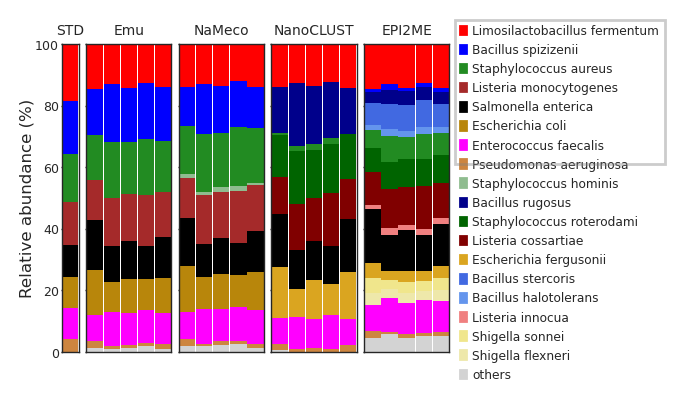

In [48]:
# species

# Here I manually select colors to plot taxonomies with similar colors
# for closely classified clusters
CDICT = {
    'Limosilactobacillus fermentum': 'red',
    'Bacillus spizizenii': 'blue',
    'Bacillus subtilis': 'navy',
    'Bacillus rugosus': 'darkblue',
    'Bacillus stercoris': 'royalblue',
    'Bacillus halotolerans': 'cornflowerblue',
    'Bacillus velezensis': 'steelblue',
    'Bacillus mojavensis': 'blueviolet',
    'Bacillus cabrialesii': 'indigo',
    'Staphylococcus aureus': 'forestgreen',
    'Staphylococcus roterodami': 'darkgreen',
    'Staphylococcus hominis': 'darkseagreen',
    'Staphylococcus schweitzeri': 'springgreen',
    'Staphylococcus argenteus': 'limegreen',
    'Listeria monocytogenes': 'brown',
    'Listeria cossartiae': 'maroon',
    'Listeria innocua': 'lightcoral',
    'Listeria marthii': 'salmon',
    'Listeria farberi': 'chocolate',
    'Salmonella enterica': 'black',
    'Escherichia coli': 'darkgoldenrod',
    'Escherichia fergusonii': 'goldenrod',
    'Escherichia marmotae': 'gold',
    'Shigella sonnei': 'khaki',
    'Shigella flexneri': 'palegoldenrod',
    'Shigella boydii': 'ivory',
    'Enterococcus faecalis': 'fuchsia',
    'Pseudomonas aeruginosa': 'peru',
    'Laceyella tengchongensis': 'saddlebrown',
    'Campylobacter lari': 'yellow',
    'Campylobacter coli': 'orange',
    'Acidovorax temperans': 'teal',
    'Streptococcus pyogenes': 'slategray',
    'Unknown': 'dimgray',
    'others': 'lightgrey',
}

rows, cols = 1, len(TOOLS)
ra, pv = 0.01, 0.4

#figure
fig, axes = plt.subplots(rows, cols, figsize=(2.5, 2), sharey='row',
            gridspec_kw={'wspace': .1, 'width_ratios': [1] + [5]*(cols-1)})
#axs, i = [[r, c] for r in range(rows) for c in range(cols)], 0

STD = pd.read_csv(f'{RAs}/STD_ra.tsv', sep='\t', index_col=0).T
legend = STD.columns.tolist() + [ c for c in CDICT.keys() if c not in STD.columns.tolist()]
labels = STD.columns.tolist()

#data
for i, tool in enumerate(TOOLS):
    if tool == TOOLS[0]:
        df = STD
    else:
        df = pd.read_csv(f'{RAs}/{tool}_ra.tsv', sep='\t', index_col=0).T
        df = df.fillna(0)
        others = [c for c in df.columns if df[c].mean() < ra or len(df.loc[df[c]>0])/len(df) < pv]
        df['others'] = df[others].sum(axis=1)
        df.drop(inplace=True, columns=others)
        [print(c) for c in df.columns if c not in CDICT]
        labels += [c for c in CDICT.keys() if c not in labels if c in df.columns.tolist()]
        #df.index = df.index.str.strip('CS') + 'S'
    df = df.reindex([c for c in list(CDICT.keys())[::-1] if c in df.columns.tolist()], axis=1)
    display(tool, df)
    
    #plot
    #ax, i = axes[axs[i][0]][axs[i][1]], i+1
    ax = axes[i]
    data = df.copy()*100
    bottom = [0]*len(data)
    for col in data.columns: #iterate through all features
        c = CDICT[col]
        ax.bar(x=data.index, height=data[col], bottom=bottom, color=c, 
               label=col, width=.95, linewidth=0)
        bottom = [a + b for a, b in zip(bottom, data[col].tolist())] #update bottom 
        

    #aesthetics
    ax.tick_params(axis='both', labelsize=4.5, pad=.5, length=.5, width=0.5) #adjust ticks
    ax.tick_params(axis='x', rotation=90) #adjust ticks
    ax.set_xticks([])
    ax.set_ylim(0, 100) #set limit for y axis
    ax.set_xlim(-.5, len(data.index) - .5) #set limit for x axis
    ax.set_ylabel('', fontsize=6.5, labelpad=0)
    ax.text(0.5, 1.03, tool, ha='center', fontsize=5, transform=ax.transAxes)
    if tool == TOOLS[0]:
        ax.set_ylabel(f'Relative abundance (%)', fontsize=6, labelpad=0)
        
#legend
labels.append(labels.pop(labels.index('others')))
handles = [mpatches.Patch(color=CDICT[l], label=l) for l in labels]
[print('not in legend', c) for c in CDICT if c not in labels]

leg = ax.legend(handles, labels ,loc=2, bbox_to_anchor=(1, 1.1), fontsize=4.4, frameon=False,
                handletextpad=0.5, handlelength=0.5, bbox_transform=ax.transAxes,
                )

fig.patches.extend([plt.Rectangle((.912, .58), 0.42, 0.36, fill=False, color='grey', alpha=0.4,
                                  transform=fig.transFigure, figure=fig)])

#fig.suptitle('Sample IDs', fontsize=5, y=.01, x=.5)
plt.savefig(f'Figures/Taxabarplot_tools_Zymo_Com_species.svg')

'STD'

,Pseudomonas,Enterococcus,Escherichia,Salmonella,Listeria,Staphylococcus,Bacillus,Limosilactobacillus
D6306,0.042,0.099,0.101,0.104,0.141,0.155,0.174,0.184


Lactobacillus


'Emu'

,others,Laceyella,Pseudomonas,Enterococcus,Shigella,Escherichia,Salmonella,Listeria,Staphylococcus,Bacillus,Limosilactobacillus
C1S,0.001572,0.002874,0.022116,0.086320,0.003256,0.145731,0.163098,0.129966,0.145097,0.152366,0.145929
C2S,0.001206,0.002892,0.008070,0.109474,0.002540,0.100030,0.114890,0.157044,0.181896,0.188998,0.130979
C3S,0.001384,0.002757,0.011833,0.101977,0.002996,0.111079,0.125073,0.149853,0.169382,0.177946,0.143528
C4S,0.001316,0.009842,0.009165,0.106758,0.002641,0.100226,0.109876,0.166121,0.179731,0.185447,0.126579
C5S,0.001005,0.002552,0.013915,0.100429,0.003670,0.116235,0.130315,0.146916,0.167814,0.174873,0.141145


'NaMeco'

,others,Campylobacter,Pseudomonas,Enterococcus,Escherichia,Salmonella,Listeria,Staphylococcus,Bacillus,Limosilactobacillus
C1S,0.0,0.009778,0.023194,0.087791,0.147631,0.156219,0.132233,0.166492,0.136300,0.140361
C2S,0.0,0.007888,0.007748,0.114057,0.102647,0.107567,0.157537,0.198739,0.174596,0.129221
C3S,0.0,0.011758,0.011961,0.103502,0.112713,0.117229,0.150399,0.192348,0.163135,0.136955
C4S,0.0,0.009617,0.008843,0.109422,0.106276,0.102473,0.168869,0.207546,0.167728,0.119226
C5S,0.0,0.007533,0.013570,0.108388,0.124623,0.131316,0.150630,0.185315,0.138935,0.139689


'NanoCLUST'

,others,Pseudomonas,Enterococcus,Escherichia,Salmonella,Listeria,Staphylococcus,Bacillus,Limosilactobacillus
C1S,0.0,0.020978,0.083089,0.165377,0.172218,0.121602,0.147863,0.149476,0.139398
C2S,0.0,0.008744,0.105067,0.091844,0.123833,0.149356,0.190680,0.203431,0.127045
C3S,0.0,0.012410,0.094760,0.124951,0.127727,0.140383,0.175625,0.186219,0.137926
C4S,0.0,0.009599,0.108665,0.103592,0.120795,0.172177,0.178988,0.182913,0.123272
C5S,0.0,0.021677,0.085363,0.151761,0.174111,0.127563,0.146112,0.150024,0.143389


'EPI2ME'

,others,Pseudomonas,Enterococcus,Shigella,Escherichia,Salmonella,Listeria,Staphylococcus,Bacillus,Limosilactobacillus
C1S,0.001349,0.021339,0.084687,0.094274,0.064058,0.172841,0.126709,0.144166,0.145710,0.144867
C2S,0.000669,0.007982,0.110441,0.068724,0.037500,0.118334,0.154499,0.186164,0.184353,0.131334
C3S,0.000979,0.011332,0.101334,0.075209,0.045991,0.132648,0.146915,0.170931,0.171983,0.142678
C4S,0.001209,0.008868,0.106697,0.069918,0.041915,0.117754,0.163955,0.183458,0.180536,0.125690
C5S,0.001115,0.013639,0.100371,0.081389,0.048768,0.138139,0.139749,0.174051,0.158040,0.144738


not in legend Acidovorax
not in legend Streptococcus
not in legend Unknown


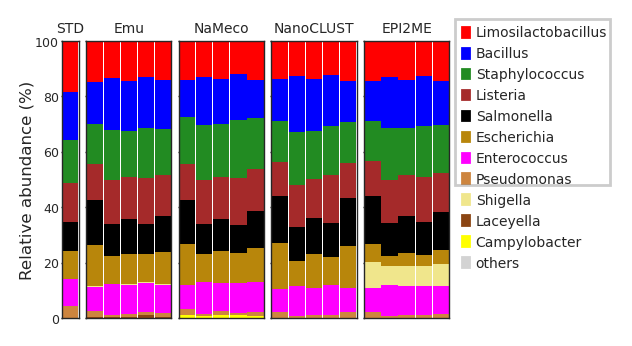

In [49]:
# genera

# Here I manually select colors to plot taxonomies with similar colors
# for closely classified clusters
CDICT = {
    'Limosilactobacillus': 'red',
    'Bacillus': 'blue',
    'Staphylococcus': 'forestgreen',
    'Listeria': 'brown',
    'Salmonella': 'black',
    'Escherichia': 'darkgoldenrod',
    'Shigella': 'khaki',
    'Enterococcus': 'fuchsia',
    'Pseudomonas': 'peru',
    'Campylobacter': 'yellow',
    'Laceyella': 'saddlebrown',
    'Acidovorax': 'teal',
    'Streptococcus': 'slategray',
    'Unknown': 'dimgray',
    'others': 'lightgrey',
}

rows, cols = 1, len(TOOLS)
ra, pv = 0.001, .4 #rel.ab. and prev. thresholds

#figure
fig, axes = plt.subplots(rows, cols, figsize=(2.5, 1.8), sharey='row',
            gridspec_kw={'wspace': .1, 'width_ratios': [1] + [5]*(cols-1)})
#axs, i = [[r, c] for r in range(rows) for c in range(cols)], 0

STD = pd.read_csv(f'{RAs}/STD_ra.tsv', sep='\t', index_col=0).T
STD.columns = [c.split(' ')[0] for c in STD.columns]
legend = STD.columns.tolist() + [ c for c in CDICT.keys() if c not in STD.columns.tolist()]
labels = STD.columns.tolist()

#data
for i, tool in enumerate(TOOLS):
    if tool == TOOLS[0]:
        df = STD
    else:
        df = pd.read_csv(f'{RAs}/{tool}_ra.tsv', sep='\t', index_col=0).T
        df = df.fillna(0)
        df.columns = [c.split(' ')[0] for c in df.columns]
        df = df.T.groupby(level=0).sum().T #sum duplicates
        others = [c for c in df.columns if df[c].mean() < ra or len(df.loc[df[c]>0])/len(df) < pv]
        df['others'] = df[others].sum(axis=1)
        df.drop(inplace=True, columns=others)
        [print(c) for c in df.columns if c not in CDICT]
        labels += [c for c in CDICT.keys() if c not in labels if c in df.columns.tolist()]
        #df.index = df.index.str.strip('CS') + 'S'
    df = df.reindex([c for c in list(CDICT.keys())[::-1] if c in df.columns.tolist()], axis=1)
    display(tool, df)
    
    #plot
    #ax, i = axes[axs[i][0]][axs[i][1]], i+1
    ax = axes[i]
    data = df.copy()*100
    bottom = [0]*len(data)
    for col in data.columns: #iterate through all features
        c = CDICT[col]
        ax.bar(x=data.index, height=data[col], bottom=bottom, color=c, 
               label=col, width=.95, linewidth=0)
        bottom = [a + b for a, b in zip(bottom, data[col].tolist())] #update bottom 
        

    #aesthetics
    ax.tick_params(axis='both', labelsize=4.5, pad=.5, length=.5, width=0.5) #adjust ticks
    ax.tick_params(axis='x', rotation=90) #adjust ticks
    ax.set_xticks([])
    ax.set_ylim(0, 100) #set limit for y axis
    ax.set_xlim(-.5, len(data.index) - .5) #set limit for x axis
    ax.set_ylabel('', fontsize=6.5, labelpad=0)
    ax.text(0.5, 1.03, tool, ha='center', fontsize=5, transform=ax.transAxes)
    if tool == TOOLS[0]:
        ax.set_ylabel(f'Relative abundance (%)', fontsize=6, labelpad=0)
        
#legend
labels.append(labels.pop(labels.index('others')))
handles = [mpatches.Patch(color=CDICT[l], label=l) for l in labels]
[print('not in legend', c) for c in CDICT if c not in labels]

leg = ax.legend(handles, labels ,loc=2, bbox_to_anchor=(1, 1.1), fontsize=5, frameon=False,
                handletextpad=0.5, handlelength=0.5, bbox_transform=ax.transAxes)

fig.patches.extend([plt.Rectangle((.912, .48), 0.31, 0.46, fill=False, color='grey', alpha=0.4,
                                  transform=fig.transFigure, figure=fig)])

#fig.suptitle('Sample IDs', fontsize=5, y=.01, x=.5)
plt.savefig(f'Figures/Taxabarplot_tools_Zymo_Com_genera.svg')

### Evaluate accuracy

In [50]:
ra, pv = .01, .4
mapp = pd.read_csv(f'Data/GTDB_taxonomy.tsv', sep='\t').Taxon.tolist()
mapp += ['d__Unknown;p__Unknown;c__Unknown;o__Unknown;f__Unknown;g__Unknown;s__Unknown',
        'd__Bacteria;p__Bacillota;c__Bacilli;o__Staphylococcales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus roterodami',
        'd__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Shigella;s__Shigella sonnei',
        'd__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Shigella;s__Shigella flexneri',
        'd__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Shigella;s__Shigella boydii',
        'd__Bacteria;p__Campylobacterota;c__Campylobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter lari',
        'd__Bacteria;p__Campylobacterota;c__Campylobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter coli']

def full_tax_finder(x, mapp):
    for t in mapp:
        if x in t:
            return t.split(';s_')[0] +';s__'+ x.replace(' ', '_')
    print(x)
    
for tool in TOOLS:
    df = pd.read_csv(f'{RAs}/{tool}_ra.tsv', sep='\t', index_col=0)
    df = df.fillna(0)
    df = df.loc[df.mean(axis=1) >= ra]
    df = df.loc[[i for i in df.index if len([c for c in df.columns if df.loc[i, c] > 0])/len(df.columns) >= pv]]
    df['Full'] = df.index
    df['Full'] = df.Full.apply(lambda x: full_tax_finder(x, mapp))
    df = df.set_index('Full')
    df.to_csv(f"{ACC}/{tool}_full.tsv", sep='\t')

In [51]:
#import to qiime2

for tool in TOOLS:
    
    !biom convert \
        -i {ACC}/{tool}_full.tsv \
        -o {ACC}/{tool}_full.biom \
        --table-type="OTU table" \
        --to-json
    
    !qiime tools import \
        --type FeatureTable[RelativeFrequency] \
        --input-path {ACC}/{tool}_full.biom \
        --input-format BIOMV100Format \
        --output-path {ACC}/{tool}_full.qza

Imported Results/Tools/Accuracy/Zymo_Com/STD_full.biom as BIOMV100Format to Results/Tools/Accuracy/Zymo_Com/STD_full.qza
Imported Results/Tools/Accuracy/Zymo_Com/Emu_full.biom as BIOMV100Format to Results/Tools/Accuracy/Zymo_Com/Emu_full.qza
Imported Results/Tools/Accuracy/Zymo_Com/NaMeco_full.biom as BIOMV100Format to Results/Tools/Accuracy/Zymo_Com/NaMeco_full.qza
Imported Results/Tools/Accuracy/Zymo_Com/NanoCLUST_full.biom as BIOMV100Format to Results/Tools/Accuracy/Zymo_Com/NanoCLUST_full.qza
Imported Results/Tools/Accuracy/Zymo_Com/EPI2ME_full.biom as BIOMV100Format to Results/Tools/Accuracy/Zymo_Com/EPI2ME_full.qza


In [52]:
# accuracy

for tool in tools:
    
    #composition accuracy
    !qiime quality-control evaluate-composition \
        --i-expected-features {ACC}/STD_full.qza \
        --i-observed-features {ACC}/{tool}_full.qza \
        --m-metadata-file Data/Zymo_Com/mock_map.tsv \
        --m-metadata-column Mock \
        --o-visualization {ACC}/{tool}_accuracy.qzv

Saved Visualization to: Results/Tools/Accuracy/Zymo_Com/Emu_accuracy.qzv
Saved Visualization to: Results/Tools/Accuracy/Zymo_Com/NaMeco_accuracy.qzv
Saved Visualization to: Results/Tools/Accuracy/Zymo_Com/NanoCLUST_accuracy.qzv
Saved Visualization to: Results/Tools/Accuracy/Zymo_Com/EPI2ME_accuracy.qzv


In [10]:
# pool

def get_accuracy(qza):
    a = !unzip {qza}
    out = a[1].split('/')[0].replace('  inflating: ','')
    fneg = pd.read_csv(f"{out}/data/false_negative_features.tsv", index_col=0, sep='\t')
    misc = pd.read_csv(f"{out}/data/misclassifications.tsv", index_col=0, sep='\t')
    ress = pd.read_csv(f"{out}/data/results.tsv", index_col=0, sep='\t')
    !rm -rf {out}
    return fneg, misc, ress


expected = TOOLS[0]
dfs = []
tabs = ['fneg', 'misc', 'ress']

for tool in tools:
        
    qza = f"{ACC}/{tool}_accuracy.qzv"
    fneg, misc, ress = get_accuracy(qza)
    for df in (fneg, misc, ress):
        df['Tool'] = tool
        df.index = df.index.astype(str).str.split('s__').str[-1].str.replace('_', ' ')
    ress = ress.loc[ress.level > 5]
    dfs.append([fneg, misc, ress])

for i, tab in enumerate(tabs):
    df = pd.concat([t[i] for t in dfs if len(t[i]) != 0])
    df.to_csv(f"{ACC}/{tab}_accuracy.tsv", sep='\t')
    display(df)

,D6306,Tool
Taxon,,
Bacillus spizizenii,0.174,NanoCLUST
Listeria monocytogenes,0.141,NanoCLUST
Escherichia coli,0.101,NanoCLUST
Listeria monocytogenes,0.141,EPI2ME
Escherichia coli,0.101,EPI2ME


,C1S,C2S,C3S,C4S,C5S,Tool
Taxon,,,,,,
Staphylococcus hominis,0.010987,0.011060,0.014650,0.017900,0.006730,NaMeco
Bacillus rugosus,0.149476,0.203431,0.186219,0.182913,0.150024,NanoCLUST
Listeria cossartiae,0.121602,0.149356,0.140383,0.172177,0.127563,NanoCLUST
Staphylococcus roterodami,0.134213,0.174116,0.153860,0.159662,0.146112,NanoCLUST
Escherichia fergusonii,0.165377,0.091844,0.124951,0.103592,0.151761,NanoCLUST
Bacillus halotolerans,0.016404,0.022577,0.019719,0.022440,0.019711,EPI2ME
Bacillus rugosus,0.037156,0.045549,0.044967,0.044492,0.036810,EPI2ME
Bacillus stercoris,0.071253,0.081153,0.083148,0.085484,0.074741,EPI2ME
Listeria cossartiae,0.109029,0.129613,0.125761,0.139190,0.116181,EPI2ME


,sample,level,Observed Taxa,Observed / Expected Taxa,TAR,TDR,Slope,Intercept,r-value,P value,Std Err,Bray-Curtis,Jaccard,r-squared,Tool
25,C1S,6,8,1.000,1.000000,1.000,0.730667,0.032195,0.734347,0.038027,0.275720,0.110328,0.000000,0.539266,Emu
26,C2S,6,8,1.000,1.000000,1.000,1.058392,-0.008661,0.876861,0.004247,0.236894,0.082924,0.000000,0.768885,Emu
27,C3S,6,8,1.000,1.000000,1.000,1.000215,-0.001535,0.907178,0.001863,0.189385,0.064998,0.000000,0.822972,Emu
28,C4S,6,8,1.000,1.000000,1.000,1.036917,-0.007104,0.864522,0.005602,0.246099,0.081889,0.000000,0.747399,Emu
29,C5S,6,8,1.000,1.000000,1.000,0.951490,0.004645,0.890567,0.003013,0.198396,0.067137,0.000000,0.793110,Emu
30,C1S,7,8,1.000,1.000000,1.000,0.730667,0.032195,0.734347,0.038027,0.275720,0.110328,0.000000,0.539266,Emu
31,C2S,7,8,1.000,1.000000,1.000,1.058392,-0.008661,0.876861,0.004247,0.236894,0.082924,0.000000,0.768885,Emu
32,C3S,7,8,1.000,1.000000,1.000,1.000215,-0.001535,0.907178,0.001863,0.189385,0.064998,0.000000,0.822972,Emu
33,C4S,7,8,1.000,1.000000,1.000,1.036917,-0.007104,0.864522,0.005602,0.246099,0.081889,0.000000,0.747399,Emu
34,C5S,7,8,1.000,1.000000,1.000,0.951490,0.004645,0.890567,0.003013,0.198396,0.067137,0.000000,0.793110,Emu


In [23]:
#false negatives
df = pd.read_csv(f"{ACC}/fneg_accuracy.tsv", sep='\t', index_col=0)
df['Standard'] = 'zCom'
df = df[['Standard','D6306', 'Tool']]
df.to_csv(f"{ACC}/fneg_accuracy.tsv", sep='\t')

#misclassifications
df = pd.read_csv(f"{ACC}/misc_accuracy.tsv", sep='\t', index_col=0)
df['Average'] = df[SAMPLES].mean(axis=1)
df['Standard'] = 'zCom'
df = df.sort_values(['Tool','Average'])
df = df[['Standard','Average', 'Tool']]
df.to_csv(f"{ACC}/misc_accuracy.tsv", sep='\t')


In [63]:
#stat analyses (t-test)

#parse formula. Borrowed from https://github.com/qiime2/q2-longitudinal
def parse_formula(formula): 
    from patsy import ModelDesc
    from statsmodels.formula.api import ols
    if '~' not in formula:
        raise ValueError('Formula not valid: missing tilde.\n')
    if ';' in formula or formula.strip()[0].isdigit():
        metric = formula.split('~')[0].strip()
    else: metric = None
    # use patsy to parse formula
    model_desc = ModelDesc.from_formula(formula)
    group_columns = set()
    for t in model_desc.rhs_termlist:
        for i in t.factors: 
            group_columns.add(i.name())
    if metric is None:
        metric = model_desc.lhs_termlist[0].name()
    return metric, group_columns


#anova
def run_anova(formula, data, pairs=False):
    import pandas as pd
    import statsmodels.api as sm
    from patsy import ModelDesc
    from statsmodels.formula.api import ols
    
    metric, group_columns = parse_formula(formula)
    columns  = [metric] + list(group_columns)
    cats = data.select_dtypes(exclude='number').columns.tolist()
    metadata = data[columns].dropna().copy()
    lm = ols(formula, metadata).fit()
    results = pd.DataFrame(sm.stats.anova_lm(lm, typ='II')).fillna('')
    # Run pairwise t-tests with multiple test correction
    pairwise_tests = pd.DataFrame()
    for group in group_columns:
        # only run on categorical columns — numeric columns raise error
        if group in cats:
            #ttests = lm.t_test_pairwise(group, method='fdr_bh').result_frame
            #pairwise_tests = pd.concat([pairwise_tests, pd.DataFrame(ttests)])
            tukey = pairwise_tukeyhsd(metadata[metric], metadata[group])
            thsd_pairs = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
            pairwise_tests = pd.concat([pairwise_tests, pd.DataFrame(thsd_pairs)])
    if pairwise_tests.empty:
        pairwise_tests = False  
    # Plot fit vs. residuals
    metadata['residual'] = lm.resid
    metadata['fitted_values'] = lm.fittedvalues
    return results, pairwise_tests, metadata


levs = {
    'Genus': 6,
    'Species': 7,
}

renames = {
    'Observed / Expected Taxa': 'OET',
    'P value': 'P_value',
    'Std Err': 'StdErr',
    'Bray-Curtis': 'Bray_Curtis',
    'r-squared': 'r_squared',
    
}

ress = pd.read_csv(f"{ACC}/ress_accuracy.tsv", sep='\t', index_col='sample')
ress = ress.rename(columns=renames)
anova, pairwise, residuals = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
facts = ['OET', 'TAR', 'TDR', 'Slope', 'P_value', 'StdErr', 'Bray_Curtis', 'Jaccard', 'r_squared']

for lev, l in levs.items():
    df = ress.loc[ress.level == l]
    for fact in facts:
        data = df[(df[fact].notna())].copy()
        data = data[[fact, 'Tool']]
        formula= f'{fact} ~ Tool'
        results, pairwise_tests, data = run_anova(formula, data)
        results['Metric'] = pairwise_tests['Metric'] = data['Metric'] = fact
        results['Factor'] = pairwise_tests['Factor'] = data['Factor'] = 'Tool'
        results['Level'] = pairwise_tests['Level'] = data['Level'] = lev
        anova = pd.concat([anova, results])
        pairwise = pd.concat([pairwise, pairwise_tests])
        residuals = pd.concat([residuals, data])
anova.to_csv(f'{ACC}/anova.tsv', sep='\t')
pairwise.to_csv(f'{ACC}/anova_pairs.tsv', sep='\t')
residuals.to_csv(f'{ACC}/anova_residuals.tsv', sep='\t')
display(anova)

,sum_sq,df,F,PR(>F),Metric,Factor,Level
Tool,5.859375e-02,3.0,2535301200456462743643080359936.0,0.0,OET,Tool,Genus
Residual,1.232595e-31,16.0,,,OET,Tool,Genus
Tool,4.629630e-02,3.0,500800237127201148112943972352.0,0.0,TAR,Tool,Genus
Residual,4.930381e-31,16.0,,,TAR,Tool,Genus
Tool,8.762981e-32,3.0,0.947917,0.44089,TDR,Tool,Genus
Residual,4.930381e-31,16.0,,,TDR,Tool,Genus
Tool,2.388565e-01,3.0,3.654692,0.035209,Slope,Tool,Genus
Residual,3.485660e-01,16.0,,,Slope,Tool,Genus
Tool,1.909173e-03,3.0,0.784223,0.520022,P_value,Tool,Genus
Residual,1.298388e-02,16.0,,,P_value,Tool,Genus


In [55]:
# descriptive stats
levs = {
    'Genus': 6,
    'Species': 7,
}

renames = {
    'Observed / Expected Taxa': 'OET',
    'P value': 'P_value',
    'Std Err': 'StdErr',
    'Bray-Curtis': 'Bray_Curtis',
    'r-squared': 'r_squared',
    
}

ress = pd.read_csv(f"{ACC}/ress_accuracy.tsv", sep='\t', index_col='sample')
ress = ress.rename(columns=renames)
dfs = []
facts = ['OET', 'TAR', 'TDR', 'Slope', 'P_value', 'StdErr', 'Bray_Curtis', 'Jaccard', 'r_squared']

for lev, l in levs.items():
    for tool in tools:
        df = ress.loc[(ress.level == l) & (ress.Tool == tool)]
        for fact in facts:
            data = df[(df[fact].notna())].copy()
            desc = pd.DataFrame(data[fact].describe()).T.reset_index(names='Factor')
            desc[['Tool', 'Level']] = tool, lev
            dfs.append(desc)
df = pd.concat(dfs, ignore_index=True)
df = df[[c for c in df.columns if '%' not in c]]
df['mean'] = df['mean'].apply(lambda x: round(x, 3))
df['std'] = df['std'].apply(lambda x: round(x, 3))
df.to_csv(f'{ACC}/Descriptive.tsv', sep='\t', index=False)
df            

,Factor,count,mean,std,min,max,Tool,Level
0,OET,5.0,1.000,0.000,1.000000,1.000000,Emu,Genus
1,TAR,5.0,1.000,0.000,1.000000,1.000000,Emu,Genus
2,TDR,5.0,1.000,0.000,1.000000,1.000000,Emu,Genus
3,Slope,5.0,0.956,0.132,0.730667,1.058392,Emu,Genus
4,P_value,5.0,0.011,0.015,0.001863,0.038027,Emu,Genus
...,...,...,...,...,...,...,...,...
67,P_value,5.0,0.580,0.069,0.521824,0.691712,EPI2ME,Species
68,StdErr,5.0,0.171,0.004,0.166575,0.177558,EPI2ME,Species
69,Bray_Curtis,5.0,0.550,0.011,0.540160,0.566815,EPI2ME,Species
70,Jaccard,5.0,0.647,0.000,0.647059,0.647059,EPI2ME,Species


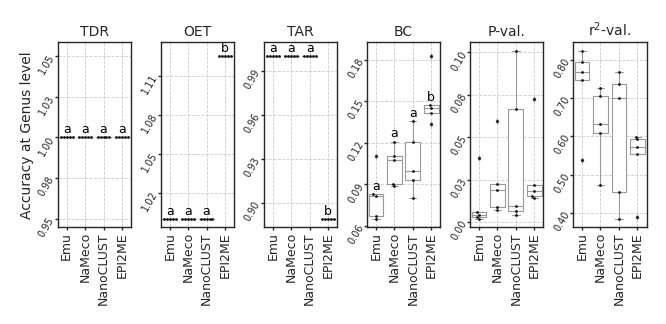

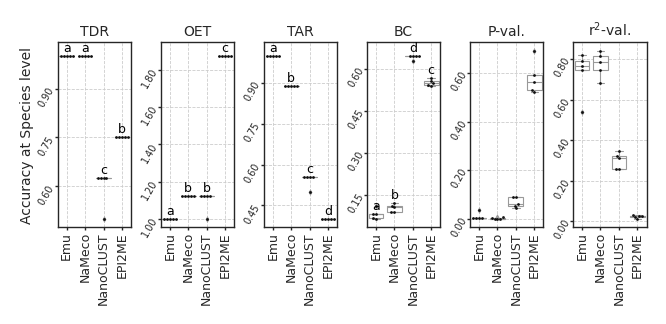

In [64]:
#plot

levs = {
    'Genus': 6,
    'Species': 7,}

renames = {
    'Observed / Expected Taxa': 'OET',
    'TAR': 'TAR', 
    'TDR': 'TDR',
    'P value': 'P_value',
    'Std Err': 'StdErr',
    'Bray-Curtis': 'Bray_Curtis',
    'r-squared': 'r_squared',}

SUBS = {
    'TDR': ['TDR', 'descending'], 
    'Observed / Expected Taxa': ["OET", 'ascending'], 
    'TAR': ['TAR', 'descending'], 
    'Bray-Curtis': ['BC', 'ascending'],
    'P value': ['P-val.'], 
    'r-squared': ['r$^2$-val.']}

pairs = pd.read_csv(f'{ACC}/anova_pairs.tsv', sep='\t')
pairs[['Group1', 'Group2']] = pairs['Unnamed: 0'].str.split('-', expand=True)
ress = pd.read_csv(f"{ACC}/ress_accuracy.tsv", sep='\t', index_col='sample')

#set figure
rows, cols = 1, len(SUBS)

for lev, l in levs.items():
    #figure
    fig, axes = plt.subplots(rows, cols, figsize=(3.8, 1.2), sharey=False,
                gridspec_kw={'wspace': .4})
    #axs, i = [[r, c] for r in range(rows) for c in range(cols)], 0
    
    for i, fact in enumerate(SUBS):
        data = ress.loc[(ress.level == l)].copy()
        data = data[(data[fact].notna())]

        ### Boxplots ###
        #ax, i = axes[axs[i][0]][axs[i][1]], i+1
        ax = axes[i]
        sns.boxplot(y=fact, x='Tool', data=data, ax=ax, linewidth=0.4, fliersize=0.3, 
                    order=tools, color='white', showfliers=True)
        #sns.violinplot(x=fact, y='Tool', data=data, ax=ax, order=order, )
        sns.swarmplot(y=fact, x='Tool', data=data, order=tools, ax=ax, size=1, 
                      alpha=0.9, legend=False, c='black')
        ax.tick_params(axis='both', labelsize=3.5, length=1, pad=-.5, width=0.5,rotation=60 )
        ax.tick_params(axis='x', labelsize=4.5, rotation=90, pad=.5)
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        #ax.tick_params(axis='y', labelsize=5, rotation=315, va='bottom')
        #ax.set_yticklabels([l.replace('_', '\n(')+')' for l in order])
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.grid(lw=.3, ls='--')
        if fact == list(SUBS.keys())[0]: 
            ax.set_ylabel(f'Accuracy at {lev} level', fontsize=5, labelpad=1)
        #else:
        #    ax.tick_params(axis='y', labelsize=0, rotation=90, labelcolor='white', pad=-1)
        ax.text(.5, 1.04, SUBS[fact][0], ha='center', fontsize=5, transform=ax.transAxes)
        #[axc.set_linewidth(0.5) for axc in ax.collections]
        
        
        if fact not in ['P value', 'r-squared']:
            #cld
            statsdf = pairs.loc[(pairs.Level == lev) & (pairs.Metric == renames[fact])].copy()
            cld = cld4py.assign_letters(statsdf, 'Group1', 'Group2', 'pvalue-fdr_bh', 
                  order=SUBS[fact][1], data=data, vals=fact, group='Tool', param=True)
            #display(cld)
            cld4py.plot_letters(cld=cld, data=data, figax=ax, axis='x', plot='boxplot', pos='upper', 
                       vals=fact, group='Tool', pad=1, c='black', fs=4.5, lim=3)
    
    plt.savefig(f'Figures/Accuracy_Zymo_Com_{lev}.svg')

## Zymo_Gut

In [116]:
TOOLS = [
    'STD',
    'Emu',
    'NaMeco',
    'NanoCLUST',
    'EPI2ME',
]

RAs = 'Results/Tools/RAs/Zymo_Gut'
ACC = 'Results/Tools/Accuracy/Zymo_Gut'
SAMPLES = [f"zymogut{n:02d}" for n in range(1,11)]
tools = TOOLS[1:]

!mkdir -p {RAs} {ACC}

In [55]:
SAMPLES

['zymogut01',
 'zymogut02',
 'zymogut03',
 'zymogut04',
 'zymogut05',
 'zymogut06',
 'zymogut07',
 'zymogut08',
 'zymogut09',
 'zymogut10']

### RAs

In [66]:
# Zymo_Gut
df = pd.read_csv('Data/Zymo_Gut/standard.tsv', sep='\t', index_col=0)
df = df.div(df.sum(axis=0), axis=1)
df = df.sort_values(by='D6331', ascending=False)
df.index = df.index.str.replace('Lacto', 'Limosilacto')\
                   .str.replace('nucleatum', 'animalis*')
df.to_csv(f'{RAs}/STD_ra.tsv', sep='\t')

In [88]:
# NaMeco
df = pd.read_csv(f'Results/Tools/Tool_outs/NaMeco_Zymo_Gut/Species_counts.tsv', 
                 sep='\t', index_col=0)
df = df.div(df.sum(axis=0), axis=1)
df.index = df.index.str.replace('genes B', 'genes').str.replace('er D', 'er')\
           .str.replace('malis', 'malis*').str.replace('zii E', 'zii')
df = df.groupby(df.index).sum()
df = df.reindex(df.mean(axis=1).sort_values(ascending=False).index, axis=0)
df = df[sorted(df.columns.tolist())]
df.to_csv(f'{RAs}/NaMeco_ra.tsv', sep='\t')

In [83]:
# Emu
df = pd.DataFrame()
for s in SAMPLES:
    emu = pd.read_csv(f'Results/Tools/Tool_outs/Emu_Zymo_Gut/{s}.fastq_rel-abundance.tsv', 
                     sep='\t', index_col='species')
    emu = emu[emu.index.notnull()]
    df[s] = emu['abundance']
#df = df.div(df.sum(axis=0), axis=1)
df.index = df.index.str.replace('genes_B', 'genes').str.replace('er_D', 'er')\
            .str.replace('nucleatum', 'animalis*')
df = df.groupby(df.index).sum()
df = df.reindex(df.mean(axis=1).sort_values(ascending=False).index, axis=0)
df = df[sorted(df.columns.tolist())]
df.to_csv(f'{RAs}/Emu_ra.tsv', sep='\t')

In [4]:
# Emu GTDB
reps = {
    'genes_B': 'genes', 'er_D': 'er', 'tzii_A': 'tzii', 'tzii_A': 'tzii', 'tzii_M': 'tzii', 
    'tzii_D': 'tzii', 'tzii_E': 'tzii', 'tzii_J': 'tzii', 'osa_B': 'osa', 'difficile_A': 'difficile', 
    'coli_F': 'coli', 'parvula_A': 'parvula', 'copri_C': 'copri', 'animalis': 'animalis*', 'Sarcina': 'Clostridium'}

df = pd.DataFrame()
for s in SAMPLES:
    emu = pd.read_csv(f'Results/Tools/Tool_outs/Emu_Zymo_Gut_GTDB/{s}.fastq_rel-abundance.tsv', 
                     sep='\t', index_col='Taxon')
    emu = emu[emu.index.notnull()]
    df[s] = emu['abundance']
#df = df.div(df.sum(axis=0), axis=1)
for k,v in reps.items():
    df.index = df.index.str.replace(k,v)
df = df.groupby(df.index).sum()
df = df.reindex(df.mean(axis=1).sort_values(ascending=False).index, axis=0)
df = df[sorted(df.columns.tolist())]
df.to_csv(f'{RAs}/Emu_ra_GTDB.tsv', sep='\t')

In [90]:
# NanoCLUST
df = pd.DataFrame()
for s in SAMPLES:
    nc = pd.read_csv(f'Results/Tools/Tool_outs/NanoCLUST_Zymo_Gut_NCBI/rel_abundance_{s}.fastq_S.csv', 
                     sep=',', index_col=0)
    df[s] = nc.rel_abundance
df.index = df.index.str.replace('malis', 'malis*')    
df = df.div(df.sum(axis=0), axis=1)  
df = df.reindex(df.mean(axis=1).sort_values(ascending=False).index, axis=0)
df = df[sorted(df.columns.tolist())]
df.to_csv(f'{RAs}/NanoCLUST_ra.tsv', sep='\t')   

In [97]:
# EPI2ME
df = pd.read_csv(f'Results/Tools/Tool_outs/EPI2ME_Zymo_Gut.tsv', sep='\t', index_col='tax')
df.index = df.index.str.split(';').str[-1].str.replace('malis', 'malis*')
df = df[SAMPLES]
df = df.div(df.sum(axis=0), axis=1)
df = df.reindex(df.mean(axis=1).sort_values(ascending=False).index, axis=0)
df.to_csv(f'{RAs}/EPI2ME_ra_unkn.tsv', sep='\t')

In [98]:
# EPI2ME (no 'Unknown')
df = pd.read_csv(f'Results/Tools/Tool_outs/EPI2ME_Zymo_Gut.tsv', sep='\t', index_col='tax')
df.index = df.index.str.split(';').str[-1].str.replace('malis', 'malis*')
df = df[SAMPLES]
df = df.loc[df.index != 'Unknown']
df = df.div(df.sum(axis=0), axis=1)
df = df.reindex(df.mean(axis=1).sort_values(ascending=False).index, axis=0)
df.to_csv(f'{RAs}/EPI2ME_ra.tsv', sep='\t')

### Barplots

'STD'

Standard,others,Akkermansia muciniphila,Clostridioides difficile,Prevotella corporis,Fusobacterium animalis*,Bifidobacterium adolescentis,Limosilactobacillus fermentum,Roseburia hominis,Bacteroides fragilis,Escherichia coli,Veillonella rogosae,Faecalibacterium prausnitzii
D6331,0.000111,0.009699,0.026197,0.049794,0.074992,0.08789,0.096389,0.098989,0.099489,0.121287,0.158782,0.17638


'Emu'

species,others,Clostridioides difficile,Prevotella corporis,Fusobacterium animalis*,Limosilactobacillus fermentum,Roseburia hominis,Bacteroides fragilis,Shigella dysenteriae,Escherichia coli,Veillonella dispar,Veillonella parvula,Faecalibacterium prausnitzii
zymogut01,0.006862,0.032389,0.006505,0.014310,0.184478,0.175714,0.006966,0.001647,0.165564,0.015532,0.258439,0.131592
zymogut02,0.003852,0.031794,0.005546,0.014015,0.168322,0.149546,0.008204,0.001664,0.211409,0.006451,0.243661,0.155498
zymogut03,0.006928,0.031356,0.007024,0.016381,0.171755,0.157032,0.006547,0.001686,0.172249,0.009973,0.298686,0.120341
zymogut04,0.003858,0.023919,0.006713,0.039372,0.185992,0.105360,0.009741,0.001683,0.266730,0.003836,0.170936,0.181861
zymogut05,0.002623,0.030390,0.004212,0.007430,0.168418,0.126328,0.006371,0.001869,0.280201,0.002190,0.207440,0.162480
zymogut06,0.003910,0.032179,0.004800,0.010777,0.165148,0.144739,0.007150,0.001828,0.230496,0.006510,0.239220,0.153203
zymogut07,0.003570,0.028299,0.003549,0.007250,0.191459,0.129333,0.005665,0.001761,0.232665,0.005859,0.207059,0.183531
zymogut08,0.004199,0.030902,0.005503,0.024909,0.159805,0.147835,0.007705,0.002003,0.216381,0.008263,0.242357,0.150138
zymogut09,0.003383,0.030946,0.010006,0.010557,0.158053,0.146055,0.012253,0.001754,0.227771,0.005043,0.246633,0.147510
zymogut10,0.002546,0.029930,0.004008,0.007960,0.155389,0.132730,0.006595,0.001897,0.283499,0.002692,0.220512,0.152240


'NaMeco'

Species,Stenotrophomonas sp023399815,Faecalimonas phoceensis,Campylobacter lari,others,Clostridioides difficile,Prevotella corporis,Fusobacterium animalis*,Ligilactobacillus sp945923665,Limosilactobacillus fermentum,Roseburia rectibacter,Roseburia hominis,Bacteroides fragilis,Escherichia albertii,Escherichia coli,Veillonella dispar,Veillonella rogosae,Faecalibacterium prausnitzii
zymogut01,0.001954,0.005588,0.014159,0.012393,0.025249,0.005802,0.011159,0.023569,0.159799,0.006771,0.143018,0.006351,0.001637,0.145880,0.018204,0.282075,0.136392
zymogut02,0.002058,0.002554,0.010337,0.007051,0.028700,0.006010,0.013007,0.011039,0.157046,0.000000,0.134326,0.009006,0.001640,0.204576,0.009635,0.252716,0.150298
zymogut03,0.001953,0.003702,0.015320,0.006167,0.026862,0.007464,0.014715,0.015073,0.153989,0.000000,0.143190,0.007242,0.001297,0.136203,0.013768,0.321968,0.131085
zymogut04,0.001732,0.002112,0.008603,0.002069,0.021914,0.007214,0.036781,0.008830,0.183402,0.000000,0.082831,0.011242,0.002120,0.249640,0.005438,0.166488,0.209584
zymogut05,0.000139,0.001392,0.005401,0.001364,0.026317,0.004691,0.006821,0.005485,0.170981,0.000898,0.109897,0.006647,0.002575,0.282402,0.003564,0.203333,0.168092
zymogut06,0.001390,0.003101,0.014855,0.003171,0.030577,0.005228,0.009619,0.011607,0.155757,0.003885,0.134184,0.007754,0.001858,0.208021,0.010748,0.236295,0.161952
zymogut07,0.002435,0.003225,0.009590,0.002271,0.025309,0.003624,0.006678,0.011668,0.180992,0.001531,0.111537,0.005439,0.001972,0.212836,0.007724,0.215456,0.197715
zymogut08,0.002152,0.002942,0.011247,0.003598,0.027092,0.005943,0.023654,0.014475,0.150356,0.004657,0.110723,0.008364,0.001824,0.192756,0.013458,0.261718,0.165042
zymogut09,0.001706,0.002151,0.008263,0.001802,0.027526,0.011245,0.010095,0.008767,0.151789,0.001610,0.106832,0.013663,0.001706,0.219086,0.007951,0.263264,0.162544
zymogut10,0.001161,0.001550,0.009177,0.001488,0.028942,0.004433,0.007767,0.005485,0.155012,0.000000,0.125321,0.007713,0.001395,0.256065,0.004893,0.219706,0.169892


'NanoCLUST'

taxid,Shimwellia blattae,Coprococcus phoceensis,others,Clostridioides difficile,Prevotella corporis,Fusobacterium animalis*,Limosilactobacillus secaliphilus,Limosilactobacillus fermentum,Roseburia intestinalis,Roseburia hominis,Bacteroides fragilis,Escherichia marmotae,Escherichia fergusonii,Veillonella parvula,Faecalibacterium hattorii,Faecalibacterium duncaniae,Faecalibacterium prausnitzii
zymogut01,0.002760,0.005605,0.00276,0.024591,0.006090,0.011969,0.005879,0.176711,0.003856,0.165627,0.006195,0.004257,0.166639,0.291997,0.024254,0.096300,0.004509
zymogut02,0.001998,0.001998,0.00000,0.024629,0.006478,0.014281,0.006183,0.166891,0.004122,0.146784,0.007509,0.002250,0.208640,0.257582,0.022862,0.125668,0.002124
zymogut03,0.001769,0.004091,0.00000,0.023951,0.006840,0.014873,0.007266,0.170595,0.006265,0.156339,0.006392,0.003281,0.167164,0.328553,0.020222,0.079970,0.002429
zymogut04,0.001992,0.000000,0.00000,0.022689,0.005770,0.040737,0.006632,0.182083,0.001602,0.094060,0.010020,0.002751,0.273392,0.176806,0.093444,0.086648,0.001376
zymogut05,0.001379,0.000000,0.00000,0.027102,0.004660,0.007481,0.001734,0.170365,0.001316,0.128991,0.006979,0.001400,0.284478,0.204677,0.047350,0.112086,0.000000
zymogut06,0.002742,0.002098,0.00000,0.029743,0.004777,0.008516,0.006106,0.159369,0.003822,0.140032,0.007145,0.002970,0.237216,0.246542,0.025194,0.121485,0.002243
zymogut07,0.002353,0.000000,0.00000,0.018742,0.003785,0.007488,0.006588,0.191263,0.002660,0.121821,0.005954,0.002639,0.235212,0.216634,0.094486,0.088041,0.002332
zymogut08,0.002888,0.003139,0.00000,0.024296,0.005462,0.018206,0.007680,0.155234,0.005085,0.147763,0.008266,0.003223,0.222345,0.254405,0.029988,0.109070,0.002951
zymogut09,0.001734,0.002402,0.00000,0.024019,0.009002,0.010840,0.002924,0.157129,0.004052,0.141693,0.012260,0.001650,0.228101,0.259117,0.077280,0.065416,0.002381
zymogut10,0.001144,0.000000,0.00000,0.030567,0.004557,0.008157,0.001831,0.158950,0.001394,0.133607,0.005972,0.001165,0.268004,0.228386,0.079777,0.076489,0.000000


'EPI2ME'

tax,others,Clostridioides difficile,Prevotella corporis,Fusobacterium animalis*,Limosilactobacillus fermentum,Roseburia hominis,Bacteroides fragilis,Shigella dysenteriae,Shigella boydii,Shigella flexneri,...,Veillonella nakazawae,Veillonella dispar,Veillonella tobetsuensis,Veillonella parvula,Veillonella rogosae,Faecalibacterium longum,Faecalibacterium butyricigenerans,Faecalibacterium hattorii,Faecalibacterium duncaniae,Faecalibacterium prausnitzii
zymogut01,0.001672,0.023815,0.005794,0.011463,0.193275,0.169478,0.006144,0.011386,0.005325,0.047014,...,0.007543,0.068950,0.005047,0.163180,0.046741,0.001856,0.025903,0.026757,0.055352,0.002823
zymogut02,0.001456,0.028035,0.005794,0.013410,0.175650,0.142714,0.008846,0.014005,0.007322,0.054002,...,0.006446,0.057420,0.003836,0.142119,0.042293,0.002304,0.030483,0.034625,0.068542,0.003008
zymogut03,0.003540,0.026273,0.007225,0.015018,0.177979,0.150106,0.007098,0.011349,0.006470,0.048966,...,0.010410,0.079613,0.005119,0.172638,0.053213,0.001934,0.024433,0.024628,0.049405,0.002190
zymogut04,0.002286,0.021248,0.006569,0.037824,0.194910,0.098297,0.010330,0.018042,0.007752,0.086297,...,0.004284,0.040917,0.003032,0.093250,0.027512,0.002286,0.034627,0.041196,0.082475,0.003293
zymogut05,0.001417,0.029130,0.004169,0.007260,0.175443,0.121174,0.006946,0.018871,0.007252,0.121263,...,0.005424,0.048792,0.002946,0.114366,0.033130,0.002091,0.032916,0.036948,0.071833,0.002676
zymogut06,0.001456,0.027785,0.004865,0.009789,0.171491,0.137688,0.007518,0.015299,0.007405,0.061060,...,0.008123,0.057797,0.003654,0.134586,0.041189,0.002198,0.029929,0.033539,0.067977,0.003024
zymogut07,0.001237,0.024891,0.003609,0.006666,0.203443,0.120314,0.006037,0.015940,0.006510,0.099464,...,0.006837,0.048435,0.003172,0.114801,0.036537,0.002736,0.037498,0.040799,0.082729,0.003513
zymogut08,0.001484,0.025597,0.005419,0.023615,0.165259,0.139472,0.008325,0.014646,0.007536,0.056260,...,0.006578,0.061366,0.004445,0.141862,0.040774,0.002150,0.029896,0.032892,0.065604,0.002855
zymogut09,0.001464,0.027553,0.010345,0.009878,0.163399,0.138303,0.013109,0.015776,0.007417,0.060689,...,0.006886,0.062418,0.004031,0.138888,0.040063,0.001954,0.028189,0.031914,0.066646,0.002841
zymogut10,0.001275,0.028894,0.004085,0.007755,0.161996,0.125768,0.007164,0.018950,0.006870,0.136821,...,0.005790,0.051840,0.002986,0.123657,0.034884,0.001798,0.027369,0.035754,0.070443,0.003142


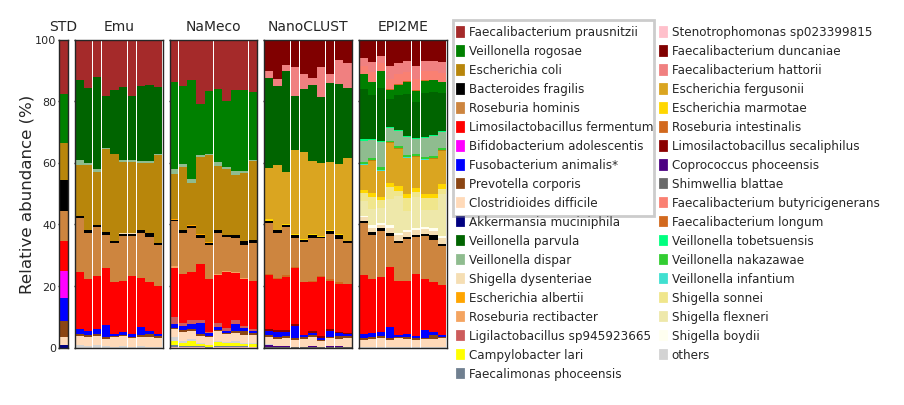

In [63]:
# species

# Here I manually select colors to plot taxonomies with similar colors
# for closely classified clusters
CDICT = {
    'Faecalibacterium prausnitzii': 'brown',
    'Faecalibacterium duncaniae': 'maroon',
    'Faecalibacterium hattorii': 'lightcoral',
    'Faecalibacterium butyricigenerans': 'salmon',
    'Faecalibacterium longum': 'chocolate',
    'Veillonella rogosae': 'green',
    'Veillonella parvula': 'darkgreen',
    'Veillonella tobetsuensis': 'springgreen',
    'Veillonella dispar': 'darkseagreen',
    'Veillonella nakazawae': 'limegreen',
    'Veillonella infantium': 'turquoise',
    'Escherichia coli': 'darkgoldenrod',
    'Escherichia fergusonii': 'goldenrod',
    'Escherichia marmotae': 'gold',
    'Escherichia albertii': 'orange',
    'Shigella sonnei': 'khaki',
    'Shigella flexneri': 'palegoldenrod',
    'Shigella boydii': 'ivory',
    'Shigella dysenteriae': 'wheat',
    'Bacteroides fragilis': 'black',
    'Roseburia hominis': 'peru',
    'Roseburia intestinalis': 'chocolate',
    'Roseburia rectibacter': 'sandybrown',
    'Limosilactobacillus fermentum': 'red',
    'Ligilactobacillus sp945923665': 'indianred',
    'Limosilactobacillus secaliphilus': 'darkred',
    'Bifidobacterium adolescentis': 'fuchsia',
    'Fusobacterium animalis*': 'blue',
    'Prevotella corporis': 'saddlebrown',
    'Clostridioides difficile': 'peachpuff',
    'Akkermansia muciniphila': 'navy',
    'others': 'lightgrey',
    'Campylobacter lari': 'yellow',
    'Faecalimonas phoceensis': 'slategray',
    'Stenotrophomonas sp023399815': 'pink',
    'Coprococcus phoceensis': 'indigo',
    'Shimwellia blattae': 'dimgray',
}

rows, cols = 1, len(TOOLS)
ra, pv = 0.001, 0.2

#figure
fig, axes = plt.subplots(rows, cols, figsize=(2.5, 2), sharey='row',
            gridspec_kw={'wspace': .1, 'width_ratios': [1] + [10]*(cols-1)})
#axs, i = [[r, c] for r in range(rows) for c in range(cols)], 0

STD = pd.read_csv(f'{RAs}/STD_ra.tsv', sep='\t', index_col=0).T
others = [c for c in STD.columns if STD[c].mean() < ra]
STD['others'] = STD[others].sum(axis=1)
STD.drop(inplace=True, columns=others)
legend = STD.columns.tolist() + [ c for c in CDICT.keys() if c not in STD.columns.tolist()]
labels = STD.columns.tolist()

#data
for i, tool in enumerate(TOOLS):
    if tool == TOOLS[0]:
        df = STD
    else:
        df = pd.read_csv(f'{RAs}/{tool}_ra.tsv', sep='\t', index_col=0).T
        df = df.fillna(0)
        others = [c for c in df.columns if df[c].mean() < ra or len(df.loc[df[c]>0])/len(df) < pv]
        df['others'] = df[others].sum(axis=1)
        df.drop(inplace=True, columns=others)
        [print(c) for c in df.columns if c not in CDICT]
        labels += [c for c in CDICT.keys() if c not in labels if c in df.columns.tolist()]
        #df.index = df.index.str.strip('zymogut') + 'S'
    df = df.reindex([c for c in list(CDICT.keys())[::-1] if c in df.columns.tolist()], axis=1)
    display(tool, df)
    
    #plot
    #ax, i = axes[axs[i][0]][axs[i][1]], i+1
    ax = axes[i]
    data = df.copy()*100
    bottom = [0]*len(data)
    for col in data.columns: #iterate through all features
        c = CDICT[col]
        ax.bar(x=data.index, height=data[col], bottom=bottom, color=c, 
               label=col, width=.95, linewidth=0)
        bottom = [a + b for a, b in zip(bottom, data[col].tolist())] #update bottom 
        

    #aesthetics
    ax.tick_params(axis='both', labelsize=4, pad=.5, length=.5, width=0.5) #adjust ticks
    ax.tick_params(axis='x', rotation=90) #adjust ticks
    ax.set_xticks([])
    ax.set_ylim(0, 100) #set limit for y axis
    ax.set_xlim(-.5, len(data.index) - .5) #set limit for x axis
    ax.set_ylabel('', fontsize=6.5, labelpad=0)
    ax.text(0.5, 1.03, tool, ha='center', fontsize=5, transform=ax.transAxes)
    if tool == TOOLS[0]:
        ax.set_ylabel(f'Relative abundance (%)', fontsize=6, labelpad=0)
        
#legend
labels.append(labels.pop(labels.index('others')))
handles = [mpatches.Patch(color=CDICT[l], label=l) for l in labels]
[print('not in legend', c) for c in CDICT if c not in labels]

leg = ax.legend(handles, labels ,loc=2, bbox_to_anchor=(1, 1.08), fontsize=4.3, frameon=False,
                handletextpad=0.5, handlelength=0.5, bbox_transform=ax.transAxes,
                ncols=2, columnspacing=.5)

fig.patches.extend([plt.Rectangle((.912, .44), 0.402, 0.490, fill=False, color='grey', alpha=0.4,
                                  transform=fig.transFigure, figure=fig)])

#fig.suptitle('Sample IDs', fontsize=5, y=.015, x=.5)
plt.savefig(f'Figures/Taxabarplot_tools_Zymo_Gut_species.svg')

'STD'

,others,Akkermansia,Clostridioides,Prevotella,Fusobacterium,Bifidobacterium,Limosilactobacillus,Roseburia,Bacteroides,Escherichia,Veillonella,Faecalibacterium
D6331,0.000111,0.009699,0.026197,0.049794,0.074992,0.08789,0.096389,0.098989,0.099489,0.121287,0.158782,0.17638


'Emu'

,others,Clostridioides,Prevotella,Fusobacterium,Limosilactobacillus,Roseburia,Bacteroides,Shigella,Escherichia,Veillonella,Faecalibacterium
zymogut01,0.002532,0.032389,0.006505,0.014310,0.184478,0.176039,0.006966,0.002850,0.165701,0.276637,0.131592
zymogut02,0.001553,0.031794,0.005546,0.014015,0.168322,0.149633,0.008204,0.002443,0.211484,0.251469,0.155498
zymogut03,0.003846,0.031356,0.007024,0.016381,0.171755,0.157204,0.006547,0.002562,0.172373,0.310569,0.120341
zymogut04,0.002306,0.023919,0.006713,0.039372,0.185992,0.105410,0.009741,0.002451,0.266761,0.175474,0.181861
zymogut05,0.001449,0.030390,0.004212,0.007430,0.168418,0.126328,0.006371,0.002444,0.280244,0.210187,0.162480
zymogut06,0.001678,0.032179,0.004800,0.010777,0.165148,0.144831,0.007150,0.002659,0.230576,0.246960,0.153203
zymogut07,0.001445,0.028299,0.003549,0.007250,0.191459,0.129431,0.005665,0.002595,0.232726,0.214050,0.183531
zymogut08,0.001580,0.030902,0.005503,0.024909,0.159805,0.147947,0.007705,0.002840,0.216466,0.252205,0.150138
zymogut09,0.001411,0.030946,0.010006,0.010557,0.158053,0.146137,0.012253,0.002537,0.227880,0.252676,0.147510
zymogut10,0.001331,0.029930,0.004008,0.007960,0.155389,0.132730,0.006595,0.002463,0.283534,0.223819,0.152240


'NaMeco'

,Stenotrophomonas,Faecalimonas,Campylobacter,others,Clostridioides,Prevotella,Fusobacterium,Ligilactobacillus,Limosilactobacillus,Roseburia,Bacteroides,Escherichia,Veillonella,Faecalibacterium
zymogut01,0.001954,0.005588,0.015393,0.003780,0.025249,0.005802,0.011159,0.023569,0.162130,0.149788,0.006351,0.147517,0.305327,0.136392
zymogut02,0.002058,0.002554,0.010337,0.002893,0.028700,0.006010,0.013007,0.011039,0.157046,0.134326,0.009006,0.206216,0.263513,0.153294
zymogut03,0.001953,0.003702,0.015534,0.004376,0.026862,0.007464,0.014715,0.015073,0.153989,0.143190,0.007242,0.137500,0.337314,0.131085
zymogut04,0.001732,0.002112,0.008603,0.001433,0.021914,0.007214,0.036781,0.008830,0.183402,0.082831,0.011242,0.251760,0.172562,0.209584
zymogut05,0.000139,0.001392,0.005568,0.001197,0.026317,0.004691,0.006821,0.005485,0.170981,0.110795,0.006647,0.284977,0.206896,0.168092
zymogut06,0.001390,0.003101,0.015837,0.000399,0.030907,0.005228,0.009619,0.011607,0.155757,0.138069,0.007754,0.209879,0.248501,0.161952
zymogut07,0.002435,0.003225,0.009775,0.000384,0.025309,0.003624,0.006678,0.011668,0.180992,0.113067,0.005439,0.214808,0.224882,0.197715
zymogut08,0.002152,0.002942,0.012189,0.000916,0.027092,0.005943,0.023654,0.014475,0.150356,0.115379,0.008364,0.194580,0.276916,0.165042
zymogut09,0.001706,0.002151,0.008508,0.000386,0.027526,0.011245,0.010095,0.008767,0.151789,0.108442,0.013663,0.220792,0.272387,0.162544
zymogut10,0.001161,0.001550,0.009380,0.000483,0.028942,0.004433,0.007767,0.005485,0.155012,0.125321,0.007713,0.257460,0.225401,0.169892


'NanoCLUST'

,Shimwellia,Coprococcus,others,Clostridioides,Prevotella,Fusobacterium,Limosilactobacillus,Roseburia,Bacteroides,Escherichia,Veillonella,Faecalibacterium
zymogut01,0.002760,0.005605,0.00276,0.024591,0.006090,0.011969,0.182590,0.169483,0.006195,0.170895,0.291997,0.125063
zymogut02,0.001998,0.001998,0.00000,0.024629,0.006478,0.014281,0.173074,0.150906,0.007509,0.210891,0.257582,0.150654
zymogut03,0.001769,0.004091,0.00000,0.023951,0.006840,0.014873,0.177861,0.162604,0.006392,0.170445,0.328553,0.102621
zymogut04,0.001992,0.000000,0.00000,0.022689,0.005770,0.040737,0.188715,0.095661,0.010020,0.276143,0.176806,0.181467
zymogut05,0.001379,0.000000,0.00000,0.027102,0.004660,0.007481,0.172100,0.130308,0.006979,0.285878,0.204677,0.159437
zymogut06,0.002742,0.002098,0.00000,0.029743,0.004777,0.008516,0.165476,0.143854,0.007145,0.240186,0.246542,0.148922
zymogut07,0.002353,0.000000,0.00000,0.018742,0.003785,0.007488,0.197852,0.124481,0.005954,0.237852,0.216634,0.184859
zymogut08,0.002888,0.003139,0.00000,0.024296,0.005462,0.018206,0.162914,0.152848,0.008266,0.225568,0.254405,0.142008
zymogut09,0.001734,0.002402,0.00000,0.024019,0.009002,0.010840,0.160053,0.145745,0.012260,0.229751,0.259117,0.145077
zymogut10,0.001144,0.000000,0.00000,0.030567,0.004557,0.008157,0.160782,0.135001,0.005972,0.269169,0.228386,0.156266


'EPI2ME'

,others,Clostridioides,Prevotella,Fusobacterium,Limosilactobacillus,Roseburia,Bacteroides,Shigella,Escherichia,Veillonella,Faecalibacterium
zymogut01,0.000996,0.023815,0.005794,0.011516,0.193293,0.169543,0.006144,0.089966,0.093163,0.293080,0.112691
zymogut02,0.000571,0.028035,0.005794,0.013446,0.175654,0.142734,0.008846,0.114370,0.118218,0.253369,0.138962
zymogut03,0.002840,0.026273,0.007225,0.015062,0.177990,0.150178,0.007098,0.092441,0.095481,0.322821,0.102590
zymogut04,0.001300,0.021248,0.006569,0.037920,0.194919,0.098341,0.010330,0.149627,0.145866,0.170002,0.163878
zymogut05,0.000694,0.029130,0.004169,0.007289,0.175443,0.121190,0.006946,0.162710,0.140292,0.205675,0.146462
zymogut06,0.000586,0.027785,0.004865,0.009838,0.171496,0.137708,0.007518,0.124104,0.132784,0.246649,0.136667
zymogut07,0.000561,0.024891,0.003609,0.006708,0.203447,0.120378,0.006037,0.137647,0.118590,0.210859,0.167274
zymogut08,0.000515,0.025597,0.005419,0.023676,0.165259,0.139516,0.008325,0.117486,0.124372,0.256437,0.133397
zymogut09,0.000599,0.027553,0.010345,0.009910,0.163408,0.138362,0.013109,0.123121,0.128209,0.253838,0.131545
zymogut10,0.000616,0.028894,0.004085,0.007765,0.162001,0.125797,0.007164,0.177344,0.127537,0.220292,0.138507


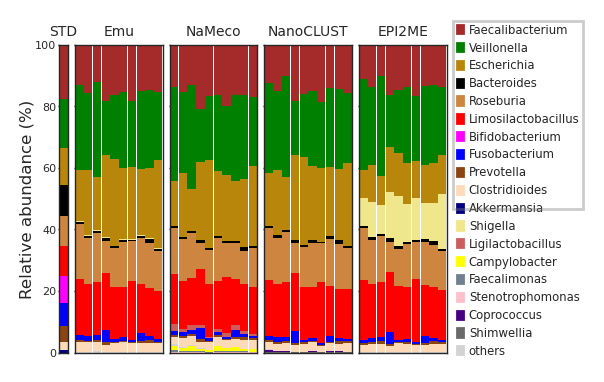

In [111]:
# genera

# Here I manually select colors to plot taxonomies with similar colors
# for closely classified clusters
CDICT = {
    'Faecalibacterium': 'brown',
    'Veillonella': 'green',
    'Escherichia': 'darkgoldenrod',
    'Shigella': 'khaki',
    'Bacteroides': 'black',
    'Roseburia': 'peru',
    'Limosilactobacillus': 'red',
    'Ligilactobacillus': 'indianred',
    'Bifidobacterium': 'fuchsia',
    'Fusobacterium': 'blue',
    'Prevotella': 'saddlebrown',
    'Clostridioides': 'peachpuff',
    'Akkermansia': 'navy',
    'others': 'lightgrey',
    'Campylobacter': 'yellow',
    'Faecalimonas': 'slategray',
    'Stenotrophomonas': 'pink',
    'Coprococcus': 'indigo',
    'Shimwellia': 'dimgray',
}

rows, cols = 1, len(TOOLS)
ra, pv = 0.001, 0.2

#figure
fig, axes = plt.subplots(rows, cols, figsize=(2.5, 2), sharey='row',
            gridspec_kw={'wspace': .1, 'width_ratios': [1] + [10]*(cols-1)})
#axs, i = [[r, c] for r in range(rows) for c in range(cols)], 0

STD = pd.read_csv(f'{RAs}/STD_ra.tsv', sep='\t', index_col=0).T
STD.columns = [c.split(' ')[0] for c in STD.columns]
others = [c for c in STD.columns if STD[c].mean() < ra]
STD['others'] = STD[others].sum(axis=1)
STD.drop(inplace=True, columns=others)
legend = STD.columns.tolist() + [ c for c in CDICT.keys() if c not in STD.columns.tolist()]
labels = STD.columns.tolist()

#data
for i, tool in enumerate(TOOLS):
    if tool == TOOLS[0]:
        df = STD
    else:
        df = pd.read_csv(f'{RAs}/{tool}_ra.tsv', sep='\t', index_col=0).T
        df = df.fillna(0)
        df.columns = [c.split(' ')[0] for c in df.columns]
        df = df.T.groupby(level=0).sum().T #sum duplicates
        others = [c for c in df.columns if df[c].mean() < ra or len(df.loc[df[c]>0])/len(df) < pv]
        df['others'] = df[others].sum(axis=1)
        df.drop(inplace=True, columns=others)
        [print(c) for c in df.columns if c not in CDICT]
        labels += [c for c in CDICT.keys() if c not in labels if c in df.columns.tolist()]
        #df.index = df.index.str.strip('zymogut') + 'S'
    df = df.reindex([c for c in list(CDICT.keys())[::-1] if c in df.columns.tolist()], axis=1)
    display(tool, df)
    
    #plot
    #ax, i = axes[axs[i][0]][axs[i][1]], i+1
    ax = axes[i]
    data = df.copy()*100
    bottom = [0]*len(data)
    for col in data.columns: #iterate through all features
        c = CDICT[col]
        ax.bar(x=data.index, height=data[col], bottom=bottom, color=c, 
               label=col, width=.95, linewidth=0)
        bottom = [a + b for a, b in zip(bottom, data[col].tolist())] #update bottom 
        

    #aesthetics
    ax.tick_params(axis='both', labelsize=4, pad=.5, length=.5, width=0.5) #adjust ticks
    ax.tick_params(axis='x', rotation=90) #adjust ticks
    ax.set_xticks([])
    ax.set_ylim(0, 100) #set limit for y axis
    ax.set_xlim(-.5, len(data.index) - .5) #set limit for x axis
    ax.set_ylabel('', fontsize=6.5, labelpad=0)
    ax.text(0.5, 1.03, tool, ha='center', fontsize=5, transform=ax.transAxes)
    if tool == TOOLS[0]:
        ax.set_ylabel(f'Relative abundance (%)', fontsize=6, labelpad=0)
        
#legend
labels.append(labels.pop(labels.index('others')))
handles = [mpatches.Patch(color=CDICT[l], label=l) for l in labels]
[print('not in legend', c) for c in CDICT if c not in labels]

leg = ax.legend(handles, labels ,loc=2, bbox_to_anchor=(1, 1.1), fontsize=4.2, frameon=False,
                handletextpad=0.5, handlelength=0.5, bbox_transform=ax.transAxes)

fig.patches.extend([plt.Rectangle((.912, .47), 0.26, 0.47, fill=False, color='grey', alpha=0.4,
                                  transform=fig.transFigure, figure=fig)])

#fig.suptitle('Sample IDs', fontsize=5, y=.015, x=.5)
plt.savefig(f'Figures/Taxabarplot_tools_Zymo_Gut_genera.svg')

### Evaluate accuracy

In [117]:
ra, pv = 0, .2
mapp = pd.read_csv(f'Data/GTDB_taxonomy.tsv', sep='\t').Taxon.tolist()
mapp += ['d__Unknown;p__Unknown;c__Unknown;o__Unknown;f__Unknown;g__Unknown;s__Unknown ',
        'd__Bacteria;p__Bacillota;c__Bacilli;o__Staphylococcales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus roterodami',
        'd__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Shigella;s__Shigella sonnei',
        'd__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Shigella;s__Shigella flexneri',
        'd__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Shigella;s__Shigella boydii',
        'd__Bacteria;p__Campylobacterota;c__Campylobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter lari',
        'd__Bacteria;p__Campylobacterota;c__Campylobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter coli',
        'd__Bacteria;p__Pseudomonadota;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Massilia;s__Massilia aquatica'
        'd__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Raoultella;s__Raoultella planticola']

def full_tax_finder(x, mapp):
    for t in mapp:
        if x.split(' ')[0] + ' ' in t:
            return t.split(';s_')[0] +';s__'+ x.replace(' ', '_')
    print(x)
    
for tool in TOOLS:
    df = pd.read_csv(f'{RAs}/{tool}_ra.tsv', sep='\t', index_col=0)
    df = df.fillna(0)
    df = df.loc[df.mean(axis=1) >= ra]
    df = df.loc[[i for i in df.index if len([c for c in df.columns if df.loc[i, c] > 0])/len(df.columns) >= pv]]
    df['Full'] = df.index
    df['Full'] = df.Full.apply(lambda x: full_tax_finder(x, mapp))
    df = df.set_index('Full')
    df.to_csv(f"{ACC}/{tool}_full.tsv", sep='\t')

In [118]:
#import to qiime2

for tool in TOOLS:
    
    !biom convert \
        -i {ACC}/{tool}_full.tsv \
        -o {ACC}/{tool}_full.biom \
        --table-type="OTU table" \
        --to-json
    
    !qiime tools import \
        --type FeatureTable[RelativeFrequency] \
        --input-path {ACC}/{tool}_full.biom \
        --input-format BIOMV100Format \
        --output-path {ACC}/{tool}_full.qza

Imported Results/Tools/Accuracy/Zymo_Gut/STD_full.biom as BIOMV100Format to Results/Tools/Accuracy/Zymo_Gut/STD_full.qza
Imported Results/Tools/Accuracy/Zymo_Gut/Emu_full.biom as BIOMV100Format to Results/Tools/Accuracy/Zymo_Gut/Emu_full.qza
Imported Results/Tools/Accuracy/Zymo_Gut/NaMeco_full.biom as BIOMV100Format to Results/Tools/Accuracy/Zymo_Gut/NaMeco_full.qza
Imported Results/Tools/Accuracy/Zymo_Gut/NanoCLUST_full.biom as BIOMV100Format to Results/Tools/Accuracy/Zymo_Gut/NanoCLUST_full.qza
Imported Results/Tools/Accuracy/Zymo_Gut/EPI2ME_full.biom as BIOMV100Format to Results/Tools/Accuracy/Zymo_Gut/EPI2ME_full.qza


In [119]:
# accuracy

for tool in tools:
    
    #composition accuracy
    !qiime quality-control evaluate-composition \
        --i-expected-features {ACC}/STD_full.qza \
        --i-observed-features {ACC}/{tool}_full.qza \
        --m-metadata-file Data/Zymo_Gut/mock_map.tsv \
        --m-metadata-column Mock \
        --o-visualization {ACC}/{tool}_accuracy.qzv

Saved Visualization to: Results/Tools/Accuracy/Zymo_Gut/Emu_accuracy.qzv
Saved Visualization to: Results/Tools/Accuracy/Zymo_Gut/NaMeco_accuracy.qzv
Saved Visualization to: Results/Tools/Accuracy/Zymo_Gut/NanoCLUST_accuracy.qzv
Saved Visualization to: Results/Tools/Accuracy/Zymo_Gut/EPI2ME_accuracy.qzv


In [120]:
# pool

def get_accuracy(qza):
    a = !unzip {qza}
    out = a[1].split('/')[0].replace('  inflating: ','')
    fneg = pd.read_csv(f"{out}/data/false_negative_features.tsv", index_col=0, sep='\t')
    misc = pd.read_csv(f"{out}/data/misclassifications.tsv", index_col=0, sep='\t')
    ress = pd.read_csv(f"{out}/data/results.tsv", index_col=0, sep='\t')
    !rm -rf {out}
    return fneg, misc, ress


expected = TOOLS[0]
dfs = []
tabs = ['fneg', 'misc', 'ress']

for tool in tools:
        
    qza = f"{ACC}/{tool}_accuracy.qzv"
    fneg, misc, ress = get_accuracy(qza)
    for df in (fneg, misc, ress):
        df['Tool'] = tool
        df.index = df.index.astype(str).str.split('s__').str[-1].str.replace('_', ' ')
    ress = ress.loc[ress.level > 5]
    dfs.append([fneg, misc, ress])

for i, tab in enumerate(tabs):
    df = pd.concat([t[i] for t in dfs if len(t[i]) != 0])
    df.to_csv(f"{ACC}/{tab}_accuracy.tsv", sep='\t')
    display(df)

,D6331,Tool
Taxon,,
Bifidobacterium adolescentis,8.789024e-02,Emu
Enterococcus faecalis,9.998890e-06,Emu
Clostridium perfringens,9.998890e-07,Emu
Bifidobacterium adolescentis,8.789024e-02,NaMeco
Clostridium perfringens,9.998890e-07,NaMeco
Bifidobacterium adolescentis,8.789024e-02,NanoCLUST
Enterococcus faecalis,9.998890e-06,NanoCLUST
Clostridium perfringens,9.998890e-07,NanoCLUST
Veillonella rogosae,1.587824e-01,NanoCLUST


,zymogut01,zymogut02,zymogut03,zymogut04,zymogut05,zymogut06,zymogut07,zymogut08,zymogut09,zymogut10,Tool
Taxon,,,,,,,,,,,
Laceyella sacchari,0.000774,0.000727,0.000665,0.000779,0.000685,0.000847,0.000688,0.000753,0.000712,0.000651,Emu
Roseburia intestinalis,0.000325,0.000088,0.000172,0.000050,0.000000,0.000092,0.000098,0.000112,0.000082,0.000000,Emu
Veillonella atypica,0.000119,0.000051,0.000093,0.000036,0.000039,0.000061,0.000048,0.000039,0.000072,0.000000,Emu
Veillonella dispar,0.015532,0.006451,0.009973,0.003836,0.002190,0.006510,0.005859,0.008263,0.005043,0.002692,Emu
Veillonella infantium,0.000088,0.000038,0.000052,0.000040,0.000046,0.000058,0.000046,0.000036,0.000000,0.000000,Emu
...,...,...,...,...,...,...,...,...,...,...,...
Salmonella bongori,0.000006,0.000004,0.000000,0.000000,0.000000,0.000005,0.000005,0.000000,0.000000,0.000000,EPI2ME
Shigella boydii,0.005325,0.007322,0.006470,0.007752,0.007252,0.007405,0.006510,0.007536,0.007417,0.006870,EPI2ME
Shigella dysenteriae,0.011386,0.014005,0.011349,0.018042,0.018871,0.015299,0.015940,0.014646,0.015776,0.018950,EPI2ME


,sample,level,Observed Taxa,Observed / Expected Taxa,TAR,TDR,Slope,Intercept,r-value,P value,Std Err,Bray-Curtis,Jaccard,r-squared,Tool
50,zymogut01,6,13,0.928571,0.846154,0.785714,1.161937,-0.010128,0.764027,0.000570,0.262237,0.337996,0.312500,0.583737,Emu
51,zymogut02,6,13,0.928571,0.846154,0.785714,1.192056,-0.012006,0.795056,0.000232,0.243047,0.314658,0.312500,0.632114,Emu
52,zymogut03,6,13,0.928571,0.846154,0.785714,1.184982,-0.011564,0.753912,0.000742,0.275979,0.345309,0.312500,0.568383,Emu
53,zymogut04,6,13,0.928571,0.846154,0.785714,1.164770,-0.010298,0.780655,0.000359,0.249213,0.267386,0.312500,0.609422,Emu
54,zymogut05,6,13,0.928571,0.846154,0.785714,1.190931,-0.011936,0.762661,0.000591,0.269935,0.317498,0.312500,0.581652,Emu
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65,zymogut06,7,39,2.785714,0.307692,0.857143,0.199617,0.016675,0.221703,0.129916,0.129450,0.709506,0.707317,0.049152,EPI2ME
66,zymogut07,7,40,2.857143,0.300000,0.857143,0.202050,0.016624,0.216286,0.139805,0.134477,0.720387,0.714286,0.046780,EPI2ME
67,zymogut08,7,37,2.642857,0.297297,0.785714,0.205637,0.016549,0.230774,0.114546,0.127836,0.695425,0.725000,0.053256,EPI2ME
68,zymogut09,7,38,2.714286,0.315789,0.857143,0.198264,0.016702,0.223164,0.127341,0.127687,0.699820,0.700000,0.049802,EPI2ME


In [121]:
#false negatives
df = pd.read_csv(f"{ACC}/fneg_accuracy.tsv", sep='\t', index_col=0)
df['Standard'] = 'zGut'
df = df[['Standard','D6331', 'Tool']]
df.to_csv(f"{ACC}/fneg_accuracy.tsv", sep='\t')

#misclassifications
df = pd.read_csv(f"{ACC}/misc_accuracy.tsv", sep='\t', index_col=0)
df['Average'] = df[SAMPLES].mean(axis=1)
df['Standard'] = 'zGut'
df = df.sort_values(['Tool','Average'])
df = df[['Standard','Average', 'Tool']]
df.to_csv(f"{ACC}/misc_accuracy.tsv", sep='\t')


In [122]:
#stat analyses (t-test)

#parse formula. Borrowed from https://github.com/qiime2/q2-longitudinal
def parse_formula(formula): 
    from patsy import ModelDesc
    from statsmodels.formula.api import ols
    if '~' not in formula:
        raise ValueError('Formula not valid: missing tilde.\n')
    if ';' in formula or formula.strip()[0].isdigit():
        metric = formula.split('~')[0].strip()
    else: metric = None
    # use patsy to parse formula
    model_desc = ModelDesc.from_formula(formula)
    group_columns = set()
    for t in model_desc.rhs_termlist:
        for i in t.factors: 
            group_columns.add(i.name())
    if metric is None:
        metric = model_desc.lhs_termlist[0].name()
    return metric, group_columns


#anova
def run_anova(formula, data, pairs=False):
    import pandas as pd
    import statsmodels.api as sm
    from patsy import ModelDesc
    from statsmodels.formula.api import ols
    
    metric, group_columns = parse_formula(formula)
    columns  = [metric] + list(group_columns)
    cats = data.select_dtypes(exclude='number').columns.tolist()
    metadata = data[columns].dropna().copy()
    lm = ols(formula, metadata).fit()
    results = pd.DataFrame(sm.stats.anova_lm(lm, typ='II')).fillna('')
    # Run pairwise t-tests with multiple test correction
    pairwise_tests = pd.DataFrame()
    for group in group_columns:
        # only run on categorical columns — numeric columns raise error
        if group in cats:
            #ttests = lm.t_test_pairwise(group, method='fdr_bh').result_frame
            #pairwise_tests = pd.concat([pairwise_tests, pd.DataFrame(ttests)])
            tukey = pairwise_tukeyhsd(metadata[metric], metadata[group])
            thsd_pairs = pd.DataFrame(data=tukey._results_table.data[1:], columns=tukey._results_table.data[0])
            pairwise_tests = pd.concat([pairwise_tests, pd.DataFrame(thsd_pairs)])
    if pairwise_tests.empty:
        pairwise_tests = False  
    # Plot fit vs. residuals
    metadata['residual'] = lm.resid
    metadata['fitted_values'] = lm.fittedvalues
    return results, pairwise_tests, metadata


levs = {
    'Genus': 6,
    'Species': 7,
}

renames = {
    'Observed / Expected Taxa': 'OET',
    'P value': 'P_value',
    'Std Err': 'StdErr',
    'Bray-Curtis': 'Bray_Curtis',
    'r-squared': 'r_squared',
    
}

ress = pd.read_csv(f"{ACC}/ress_accuracy.tsv", sep='\t', index_col='sample')
ress = ress.rename(columns=renames)
anova, pairwise, residuals = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
facts = ['OET', 'TAR', 'TDR', 'Slope', 'P_value', 'StdErr', 'Bray_Curtis', 'Jaccard', 'r_squared']

for lev, l in levs.items():
    df = ress.loc[ress.level == l]
    for fact in facts:
        data = df[(df[fact].notna())].copy()
        formula= f'{fact} ~ Tool'
        results, pairwise_tests, data = run_anova(formula, data)
        results['Metric'] = pairwise_tests['Metric'] = data['Metric'] = fact
        results['Factor'] = pairwise_tests['Factor'] = data['Factor'] = 'Tool'
        results['Level'] = pairwise_tests['Level'] = data['Level'] = lev
        anova = pd.concat([anova, results])
        pairwise = pd.concat([pairwise, pairwise_tests])
        residuals = pd.concat([residuals, data])
anova.to_csv(f'{ACC}/anova.tsv', sep='\t')
pairwise.to_csv(f'{ACC}/anova_pairs.tsv', sep='\t')
residuals.to_csv(f'{ACC}/anova_residuals.tsv', sep='\t')
display(anova)

,sum_sq,df,F,PR(>F),Metric,Factor,Level
Tool,1.907526,3.0,149.053156,0.0,OET,Tool,Genus
Residual,0.153571,36.0,,,OET,Tool,Genus
Tool,0.275841,3.0,71.882928,0.0,TAR,Tool,Genus
Residual,0.046048,36.0,,,TAR,Tool,Genus
Tool,0.315689,3.0,87.352941,0.0,TDR,Tool,Genus
Residual,0.043367,36.0,,,TDR,Tool,Genus
Tool,0.471825,3.0,201.135173,0.0,Slope,Tool,Genus
Residual,0.028150,36.0,,,Slope,Tool,Genus
Tool,0.000002,3.0,16.715698,0.000001,P_value,Tool,Genus
Residual,0.000001,36.0,,,P_value,Tool,Genus


In [123]:
# descriptive stats
levs = {
    'Genus': 6,
    'Species': 7,
}

renames = {
    'Observed / Expected Taxa': 'OET',
    'P value': 'P_value',
    'Std Err': 'StdErr',
    'Bray-Curtis': 'Bray_Curtis',
    'r-squared': 'r_squared',
    
}

ress = pd.read_csv(f"{ACC}/ress_accuracy.tsv", sep='\t', index_col='sample')
ress = ress.rename(columns=renames)
dfs = []
facts = ['OET', 'TAR', 'TDR', 'Slope', 'P_value', 'StdErr', 'Bray_Curtis', 'Jaccard', 'r_squared']

for lev, l in levs.items():
    for tool in tools:
        df = ress.loc[(ress.level == l) & (ress.Tool == tool)]
        for fact in facts:
            data = df[(df[fact].notna())].copy()
            desc = pd.DataFrame(data[fact].describe()).T.reset_index(names='Factor')
            desc[['Tool', 'Level']] = tool, lev
            dfs.append(desc)
df = pd.concat(dfs, ignore_index=True)
df = df[[c for c in df.columns if '%' not in c]]
df['mean'] = df['mean'].apply(lambda x: round(x, 3))
df['std'] = df['std'].apply(lambda x: round(x, 3))
df.to_csv(f'{ACC}/Descriptive.tsv', sep='\t', index=False)
df            

,Factor,count,mean,std,min,max,Tool,Level
0,OET,10.0,0.929,0.000,0.928571,0.928571,Emu,Genus
1,TAR,10.0,0.846,0.000,0.846154,0.846154,Emu,Genus
2,TDR,10.0,0.786,0.000,0.785714,0.785714,Emu,Genus
3,Slope,10.0,1.186,0.014,1.161937,1.207868,Emu,Genus
4,P_value,10.0,0.000,0.000,0.000225,0.000742,Emu,Genus
...,...,...,...,...,...,...,...,...
67,P_value,10.0,0.134,0.047,0.069243,0.214616,EPI2ME,Species
68,StdErr,10.0,0.132,0.004,0.127687,0.140837,EPI2ME,Species
69,Bray_Curtis,10.0,0.706,0.011,0.689179,0.720387,EPI2ME,Species
70,Jaccard,10.0,0.692,0.027,0.631579,0.725000,EPI2ME,Species


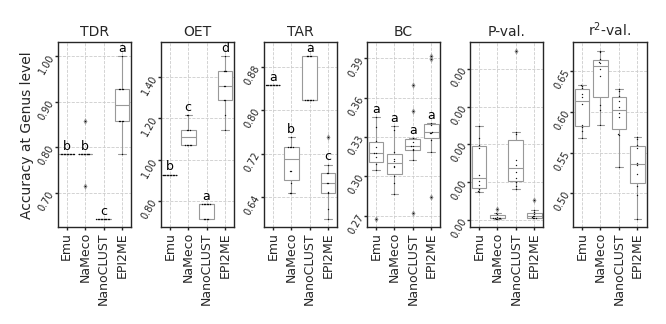

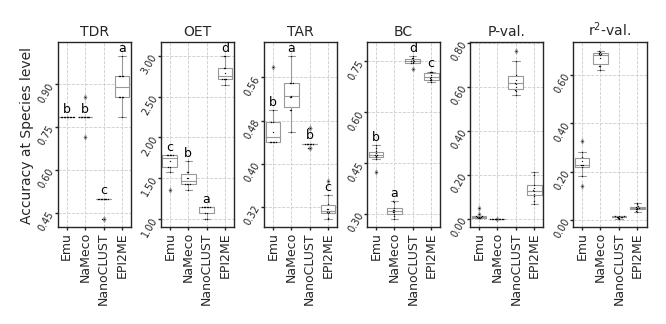

In [124]:
#plot

levs = {
    'Genus': 6,
    'Species': 7,}

renames = {
    'Observed / Expected Taxa': 'OET',
    'TAR': 'TAR', 
    'TDR': 'TDR',
    'P value': 'P_value',
    'Std Err': 'StdErr',
    'Bray-Curtis': 'Bray_Curtis',
    'r-squared': 'r_squared',}

SUBS = {
    'TDR': ['TDR', 'descending'], 
    'Observed / Expected Taxa': ["OET", 'ascending'], 
    'TAR': ['TAR', 'descending'], 
    'Bray-Curtis': ['BC', 'ascending'],
    'P value': ['P-val.'], 
    'r-squared': ['r$^2$-val.']}

pairs = pd.read_csv(f'{ACC}/anova_pairs.tsv', sep='\t')
pairs[['Group1', 'Group2']] = pairs['Unnamed: 0'].str.split('-', expand=True)
ress = pd.read_csv(f"{ACC}/ress_accuracy.tsv", sep='\t', index_col='sample')

#set figure
rows, cols = 1, len(SUBS)

for lev, l in levs.items():
    #figure
    fig, axes = plt.subplots(rows, cols, figsize=(3.8, 1.2), sharey=False,
                gridspec_kw={'wspace': .4})
    #axs, i = [[r, c] for r in range(rows) for c in range(cols)], 0
    
    for i, fact in enumerate(SUBS):
        data = ress.loc[(ress.level == l)].copy()
        data = data[(data[fact].notna())]

        ### Boxplots ###
        #ax, i = axes[axs[i][0]][axs[i][1]], i+1
        ax = axes[i]
        sns.boxplot(y=fact, x='Tool', data=data, ax=ax, linewidth=0.4, fliersize=0.3, 
                    order=tools, color='white', showfliers=True)
        #sns.violinplot(x=fact, y='Tool', data=data, ax=ax, order=order, )
        sns.swarmplot(y=fact, x='Tool', data=data, order=tools, ax=ax, size=.5, 
                      alpha=0.9, legend=False, c='black')
        ax.tick_params(axis='both', labelsize=3.5, length=1, pad=-.5, width=0.5,rotation=60 )
        ax.tick_params(axis='x', labelsize=4.5, rotation=90, pad=.5)
        ax.yaxis.set_major_locator(plt.MaxNLocator(5))
        ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
        #ax.tick_params(axis='y', labelsize=5, rotation=315, va='bottom')
        #ax.set_yticklabels([l.replace('_', '\n(')+')' for l in order])
        ax.set_ylabel('')
        ax.set_xlabel('')
        ax.grid(lw=.3, ls='--')
        if fact == list(SUBS.keys())[0]: 
            ax.set_ylabel(f'Accuracy at {lev} level', fontsize=5, labelpad=1)
        #else:
        #    ax.tick_params(axis='y', labelsize=0, rotation=90, labelcolor='white', pad=-1)
        ax.text(.5, 1.04, SUBS[fact][0], ha='center', fontsize=5, transform=ax.transAxes)
        #[axc.set_linewidth(0.5) for axc in ax.collections]
        
        
        if fact not in ['P value', 'r-squared']:
            #cld
            statsdf = pairs.loc[(pairs.Level == lev) & (pairs.Metric == renames[fact])].copy()
            #display(statsdf)
            cld = cld4py.assign_letters(statsdf, 'Group1', 'Group2', 'pvalue-fdr_bh', 
                  order=SUBS[fact][1], data=data, vals=fact, group='Tool', param=True)
            #display(cld)
            cld4py.plot_letters(cld=cld, data=data, figax=ax, axis='x', plot='boxplot', pos='upper', 
                       vals=fact, group='Tool', pad=1, c='black', fs=4.5, lim=3)
    
    plt.savefig(f'Figures/Accuracy_Zymo_Gut_{lev}.svg')

## Databases Emu

### Taxabarplots

In [170]:
ZCOM = {
    'Limosilactobacillus fermentum': 'red',
    'Bacillus spizizenii': 'blue',
    'Bacillus subtilis': 'navy',
    'Bacillus rugosus': 'darkblue',
    'Bacillus stercoris': 'royalblue',
    'Bacillus halotolerans': 'cornflowerblue',
    'Bacillus velezensis': 'steelblue',
    'Bacillus mojavensis': 'blueviolet',
    'Bacillus cabrialesii': 'indigo',
    'Staphylococcus aureus': 'forestgreen',
    'Staphylococcus roterodami': 'darkgreen',
    'Staphylococcus hominis': 'darkseagreen',
    'Staphylococcus schweitzeri': 'springgreen',
    'Staphylococcus argenteus': 'limegreen',
    'Listeria monocytogenes': 'brown',
    'Listeria cossartiae': 'maroon',
    'Listeria innocua': 'lightcoral',
    'Listeria marthii': 'salmon',
    'Listeria farberi': 'chocolate',
    'Salmonella enterica': 'black',
    'Escherichia coli': 'darkgoldenrod',
    'Escherichia fergusonii': 'goldenrod',
    'Escherichia marmotae': 'gold',
    'Shigella sonnei': 'khaki',
    'Shigella flexneri': 'palegoldenrod',
    'Shigella boydii': 'ivory',
    'Enterococcus faecalis': 'fuchsia',
    'Pseudomonas aeruginosa': 'peru',
    'Laceyella tengchongensis': 'saddlebrown',
    'Acidovorax temperans': 'teal',
    'Streptococcus pyogenes': 'slategray',
    'others': 'lightgrey',
}

ZGUT = {
    'Faecalibacterium prausnitzii': 'brown',
    'Faecalibacterium duncaniae': 'maroon',
    'Faecalibacterium hattorii': 'lightcoral',
    'Faecalibacterium butyricigenerans': 'salmon',
    'Faecalibacterium longum': 'chocolate',
    'Veillonella rogosae': 'green',
    'Veillonella parvula': 'darkgreen',
    'Veillonella tobetsuensis': 'springgreen',
    'Veillonella dispar': 'darkseagreen',
    'Veillonella nakazawae': 'limegreen',
    'Escherichia coli': 'darkgoldenrod',
    'Escherichia fergusonii': 'goldenrod',
    'Escherichia marmotae': 'gold',
    'Escherichia albertii': 'orange',
    'Shigella sonnei': 'khaki',
    'Shigella flexneri': 'palegoldenrod',
    'Shigella boydii': 'ivory',
    'Bacteroides fragilis': 'black',
    'Roseburia hominis': 'peru',
    'Limosilactobacillus fermentum': 'red',
    'Ligilactobacillus sp945923665': 'indianred',
    'Bifidobacterium adolescentis': 'fuchsia',
    'Fusobacterium animalis*': 'blue',
    'Fusobacterium nucleatum': 'darkblue',
    'Prevotella corporis': 'saddlebrown',
    'Clostridioides difficile': 'peachpuff',
    'Akkermansia muciniphila': 'navy',
    'Morganella morganii': 'indigo',
    'others': 'lightgrey',
}

def df_prep(path, tool, ra, pv, CDICT, name):
    df = pd.read_csv(f'Results/Tools/RAs/{path}/{tool}.tsv', sep='\t', index_col=0).T
    df = df.fillna(0)
    others = [c for c in df.columns if df[c].mean() < ra or len(df.loc[df[c]>0])/len(df) < pv or c not in CDICT]
    df['others'] = df[others].sum(axis=1)
    df.drop(inplace=True, columns=others)
    [print(c) for c in df.columns if c not in CDICT]
    #df.index = df.index.str.strip('zymogut') + 'S'
    df = df.reindex([c for c in list(CDICT.keys())[::-1] if c in df.columns.tolist()], axis=1)
    df.loc[name] = df.mean()
    df = pd.DataFrame(df.loc[df.index[-1]]).T
    #display(tool, df)
    return df

,others,Pseudomonas aeruginosa,Enterococcus faecalis,Escherichia coli,Salmonella enterica,Listeria monocytogenes,Staphylococcus aureus,Bacillus subtilis,Limosilactobacillus fermentum,Bacillus spizizenii,Staphylococcus hominis
Emu+EmuDB,0.012817,0.013020,0.100889,0.114653,0.128651,0.149784,0.168458,0.173714,0.137632,0.000000,0.000000
Emu+GTDB,0.023279,0.013390,0.095073,0.121768,0.125361,0.146554,0.172433,0.029370,0.138451,0.134050,0.000000
NaMeco,0.020103,0.013063,0.104632,0.118778,0.122961,0.151934,0.177823,0.000000,0.133090,0.145351,0.012265


,others,Clostridioides difficile,Prevotella corporis,Fusobacterium nucleatum,Limosilactobacillus fermentum,Roseburia hominis,Bacteroides fragilis,Escherichia coli,Veillonella dispar,Veillonella parvula,Faecalibacterium prausnitzii,Fusobacterium animalis*,Veillonella tobetsuensis,Veillonella rogosae,Faecalibacterium duncaniae,Ligilactobacillus sp945923665,Escherichia albertii
Emu+EmuDB,0.005952,0.030210,0.005787,0.015296,0.170882,0.141467,0.007720,0.228697,0.006635,0.233494,0.153840,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000
Emu+GTDB,0.012364,0.025440,0.005749,0.000000,0.171210,0.140318,0.004336,0.236853,0.000000,0.001876,0.150503,0.015326,0.001414,0.233338,0.001244,0.0000,0.000000
NaMeco,0.021268,0.026849,0.006165,0.000000,0.161912,0.120186,0.008342,0.210747,0.009538,0.000000,0.165260,0.014030,0.000000,0.242302,0.000000,0.0116,0.001802


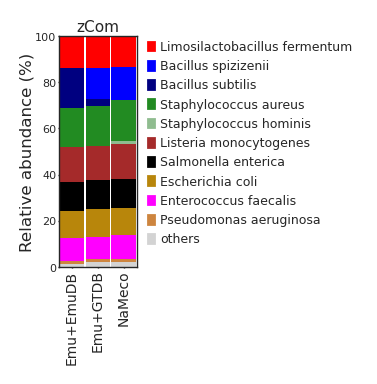

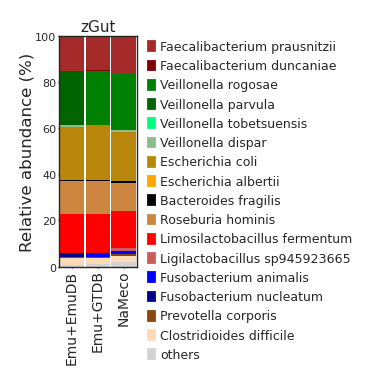

In [171]:
STDS = {
    'zCom': ['Zymo_Com', 0.01, 0.4, ZCOM],
    'zGut': ['Zymo_Gut', 0.001, 0.2, ZGUT],
}
rows, cols = 1, 1

for std in STDS:
    labels = []
    fig, ax = plt.subplots(rows, cols, figsize=(.5, 1.5))
    
    path, ra, pv, cdict = STDS[std]
    Emu_Emudb = df_prep(path, 'Emu_ra', ra, pv, cdict, 'Emu+EmuDB')
    #restore original names that were replaced before accroding to Table 1
    Emu_Emudb.columns = [c.replace('spizizenii', 'subtilis').replace('animalis*', 'nucleatum') for c in Emu_Emudb.columns]
    Emu_EmuGTDB = df_prep(path, 'Emu_ra_GTDB', ra, pv, cdict, 'Emu+GTDB')
    NaMeco = df_prep(path, 'NaMeco_ra', ra, pv, cdict, 'NaMeco')
    df = pd.concat([Emu_Emudb, Emu_EmuGTDB, NaMeco]).fillna(0)
    display(df)

    #plot
    labels = [l for l in cdict if l in df.columns]
    labels.append(labels.pop(labels.index('others')))
    data = df.copy()*100
    bottom = [0]*len(data)
    for col in labels[::-1]: #iterate through all features
        if col not in data.columns:
            continue
        c = cdict[col]
        ax.bar(x=data.index, height=data[col], bottom=bottom, color=c, 
               label=col, width=.95, linewidth=0)
        bottom = [a + b for a, b in zip(bottom, data[col].tolist())] #update bottom 
        
    #aesthetics
    ax.tick_params(axis='both', labelsize=4, pad=.5, length=.5, width=0.5) #adjust ticks
    ax.tick_params(axis='x', rotation=90, labelsize=5) #adjust ticks
    #ax.set_xticks([])
    ax.set_ylim(0, 100) #set limit for y axis
    ax.set_xlim(-.5, len(data.index) - .5) #set limit for x axis
    ax.set_ylabel('', fontsize=6.5, labelpad=0)
    ax.text(0.5, 1.02, std, ha='center', fontsize=5.5, transform=ax.transAxes)
    ax.set_ylabel(f'Relative abundance (%)', fontsize=6, labelpad=0)

    #legend
    handles = [mpatches.Patch(color=cdict[l], label=l) for l in labels]
    labels = [l.replace('*', '') for l in labels]
    #[print('not in legend', c) for c in cdict if c not in labels]
    
    leg = ax.legend(handles, labels ,loc=2, bbox_to_anchor=(1, 1.03), fontsize=4.5, frameon=False,
                    handletextpad=0.5, handlelength=0.5, bbox_transform=ax.transAxes,)
    
    #fig.patches.extend([plt.Rectangle((.912, .418), 0.42, 0.505, fill=False, color='grey', alpha=0.4,
    #                                  transform=fig.transFigure, figure=fig)])
    
    #fig.suptitle('Sample IDs', fontsize=5, y=.015, x=.5)
    plt.savefig(f'Figures/Taxabarplot_tools_Emu_databases_{std}_species.svg')

### Accuracy

In [129]:
STDS = {
    'zCom': ['Zymo_Com', 0.01, 0.4],
    'zGut': ['Zymo_Gut', 0, 0.2],
}

mapp = pd.read_csv(f'Data/GTDB_taxonomy.tsv', sep='\t').Taxon.tolist()
mapp += ['d__Unknown;p__Unknown;c__Unknown;o__Unknown;f__Unknown;g__Unknown;s__Unknown ',
        'd__Bacteria;p__Bacillota;c__Bacilli;o__Staphylococcales;f__Staphylococcaceae;g__Staphylococcus;s__Staphylococcus roterodami',
        'd__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Shigella;s__Shigella sonnei',
        'd__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Shigella;s__Shigella flexneri',
        'd__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Shigella;s__Shigella boydii',
        'd__Bacteria;p__Campylobacterota;c__Campylobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter lari',
        'd__Bacteria;p__Campylobacterota;c__Campylobacteria;o__Campylobacterales;f__Campylobacteraceae;g__Campylobacter;s__Campylobacter coli',
        'd__Bacteria;p__Pseudomonadota;c__Betaproteobacteria;o__Burkholderiales;f__Oxalobacteraceae;g__Massilia;s__Massilia aquatica'
        'd__Bacteria;p__Pseudomonadota;c__Gammaproteobacteria;o__Enterobacterales;f__Enterobacteriaceae;g__Raoultella;s__Raoultella planticola']

def full_tax_finder(x, mapp):
    for t in mapp:
        if x.split(' ')[0] + ' ' in t:
            return t.split(';s_')[0] +';s__'+ x.replace(' ', '_')
    print(x)

def df_prep(path, tool, ra, pv):
    df = pd.read_csv(f'Results/Tools/RAs/{path}/{tool}.tsv', sep='\t', index_col=0)
    df = df.fillna(0)
    df = df.loc[df.mean(axis=1) >= ra]
    df = df.loc[[i for i in df.index if len([c for c in df.columns if df.loc[i, c] > 0])/len(df.columns) >= pv]]
    df['Full'] = df.index
    df['Full'] = df.Full.apply(lambda x: full_tax_finder(x, mapp))
    df = df.set_index('Full')
    #display(df)
    return df
    

for std in STDS:
    ACC = f'Results/Tools/Accuracy/Emu_GTDB_NaMeco/{std}'

    !mkdir -p {ACC}
    
    path, ra, pv = STDS[std]
    Emu = df_prep(path, 'Emu_ra_GTDB', ra, pv)
    Emu.to_csv(f"{ACC}/Emu_GTDB_full.tsv", sep='\t')
    

In [130]:
#import to qiime2

for std in STDS:
    ACC = f'Results/Tools/Accuracy/Emu_GTDB_NaMeco/{std}'
    
    !biom convert \
        -i {ACC}/Emu_GTDB_full.tsv \
        -o {ACC}/Emu_GTDB_full.biom \
        --table-type="OTU table" \
        --to-json
    
    !qiime tools import \
        --type FeatureTable[RelativeFrequency] \
        --input-path {ACC}/Emu_GTDB_full.biom \
        --input-format BIOMV100Format \
        --output-path {ACC}/Emu_GTDB_full.qza

Imported Results/Tools/Accuracy/Emu_GTDB_NaMeco/zCom/Emu_GTDB_full.biom as BIOMV100Format to Results/Tools/Accuracy/Emu_GTDB_NaMeco/zCom/Emu_GTDB_full.qza
Imported Results/Tools/Accuracy/Emu_GTDB_NaMeco/zGut/Emu_GTDB_full.biom as BIOMV100Format to Results/Tools/Accuracy/Emu_GTDB_NaMeco/zGut/Emu_GTDB_full.qza


In [135]:
# accuracy
STDS = {
    'zCom': ['Zymo_Com', 0.01, 0.4],
    'zGut': ['Zymo_Gut', 0, 0.2],
}

for std in STDS:
    path = STDS[std][0]
    ACC = f'Results/Tools/Accuracy/Emu_GTDB_NaMeco/{std}'
    
    #composition accuracy
    !qiime quality-control evaluate-composition \
        --i-expected-features Results/Tools/Accuracy/{path}/STD_full.qza \
        --i-observed-features {ACC}/Emu_GTDB_full.qza \
        --m-metadata-file Data/{path}/mock_map.tsv \
        --m-metadata-column Mock \
        --o-visualization {ACC}/Emu_GTDB_accuracy.qzv

Saved Visualization to: Results/Tools/Accuracy/Emu_GTDB_NaMeco/zCom/Emu_GTDB_accuracy.qzv
Saved Visualization to: Results/Tools/Accuracy/Emu_GTDB_NaMeco/zGut/Emu_GTDB_accuracy.qzv


In [148]:
# pool

def get_accuracy(qza):
    a = !unzip {qza}
    out = a[1].split('/')[0].replace('  inflating: ','')
    fneg = pd.read_csv(f"{out}/data/false_negative_features.tsv", index_col=0, sep='\t')
    misc = pd.read_csv(f"{out}/data/misclassifications.tsv", index_col=0, sep='\t')
    ress = pd.read_csv(f"{out}/data/results.tsv", index_col=0, sep='\t')
    !rm -rf {out}
    return fneg, misc, ress


# accuracy
STDS = {
    'zCom': ['Zymo_Com', 0.01, 0.4],
    'zGut': ['Zymo_Gut', 0, 0.2],
}

tools = {
    'Emu+GTDB': '{ACC}/Emu_GTDB_accuracy.qzv',
    'NaMeco': 'Results/Tools/Accuracy/{path}/NaMeco_accuracy.qzv'
}

for std in STDS:
    path = STDS[std][0]
    ACC = f'Results/Tools/Accuracy/Emu_GTDB_NaMeco/{std}'

    dfs = []
    tabs = ['misc', 'ress']
    
    for tool in tools:
            
        qza = tools[tool].format(ACC=ACC, path=path)
        fneg, misc, ress = get_accuracy(qza)
        for df in (misc, ress):
            df['Tool'] = tool
            df.index = df.index.astype(str).str.split('s__').str[-1].str.replace('_', ' ')
        ress = ress.loc[ress.level > 5]
        dfs.append([misc, ress])
    
    for i, tab in enumerate(tabs):
        df = pd.concat([t[i] for t in dfs if len(t[i]) != 0])
        df.to_csv(f"{ACC}/{tab}_accuracy.tsv", sep='\t')
        display(df)

,C1S,C2S,C3S,C4S,C5S,Tool
Taxon,,,,,,
Bacillus subtilis,0.022554,0.027376,0.025964,0.030602,0.040353,Emu+GTDB
Staphylococcus hominis,0.010987,0.011060,0.014650,0.017900,0.006730,NaMeco


,sample,level,Observed Taxa,Observed / Expected Taxa,TAR,TDR,Slope,Intercept,r-value,P value,Std Err,Bray-Curtis,Jaccard,r-squared,Tool
25,C1S,6,8,1.000,1.000000,1.0,0.714519,0.033210,0.715106,0.046160,0.285138,0.117364,0.000000,0.511377,Emu+GTDB
26,C2S,6,8,1.000,1.000000,1.0,1.040503,-0.007582,0.876212,0.004313,0.233636,0.076978,0.000000,0.767747,Emu+GTDB
27,C3S,6,8,1.000,1.000000,1.0,0.977207,0.000033,0.901527,0.002214,0.191488,0.070597,0.000000,0.812752,Emu+GTDB
28,C4S,6,8,1.000,1.000000,1.0,1.005492,-0.004788,0.862956,0.005791,0.240351,0.077360,0.000000,0.744693,Emu+GTDB
29,C5S,6,8,1.000,1.000000,1.0,0.921588,0.006995,0.878913,0.004045,0.204182,0.077121,0.000000,0.772489,Emu+GTDB
30,C1S,7,9,1.125,0.888889,1.0,0.706576,0.030403,0.791154,0.011099,0.206456,0.140144,0.111111,0.625925,Emu+GTDB
31,C2S,7,9,1.125,0.888889,1.0,0.850532,0.014368,0.887312,0.001414,0.167080,0.100568,0.111111,0.787323,Emu+GTDB
32,C3S,7,9,1.125,0.888889,1.0,0.824231,0.017027,0.906780,0.000743,0.144845,0.096857,0.111111,0.822250,Emu+GTDB
33,C4S,7,9,1.125,0.888889,1.0,0.807017,0.017797,0.866071,0.002533,0.176068,0.108473,0.111111,0.750079,Emu+GTDB
34,C5S,7,9,1.125,0.888889,1.0,0.709984,0.029729,0.846872,0.003970,0.168511,0.117932,0.111111,0.717192,Emu+GTDB


,zymogut01,zymogut02,zymogut03,zymogut04,zymogut05,zymogut06,zymogut07,zymogut08,zymogut09,zymogut10,Tool
Taxon,,,,,,,,,,,
Pauljensenia sp000308055,0.000132,0.000076,0.000091,0.000081,0.000029,0.000106,0.000088,0.000079,0.000061,0.000037,Emu+GTDB
Pauljensenia sp000466265,0.000240,0.000055,0.000099,0.000032,0.000000,0.000076,0.000055,0.000055,0.000033,0.000037,Emu+GTDB
Bifidobacterium bifidum,0.000134,0.000080,0.000068,0.000086,0.000000,0.000072,0.000077,0.000069,0.000060,0.000000,Emu+GTDB
Rothia mucilaginosa,0.000115,0.000000,0.000047,0.000000,0.000000,0.000000,0.000000,0.000000,0.000032,0.000000,Emu+GTDB
Rothia sp001836735,0.000146,0.000069,0.000091,0.000031,0.000000,0.000055,0.000077,0.000077,0.000068,0.000000,Emu+GTDB
...,...,...,...,...,...,...,...,...,...,...,...
Veillonella sp900757715,0.001080,0.000563,0.000768,0.000000,0.000000,0.000737,0.000605,0.000849,0.000000,0.000000,NaMeco
Campylobacter coli,0.001234,0.000000,0.000213,0.000000,0.000167,0.000983,0.000185,0.000941,0.000245,0.000203,NaMeco
Campylobacter lari,0.014159,0.010337,0.015320,0.008603,0.005401,0.014855,0.009590,0.011247,0.008263,0.009177,NaMeco


,sample,level,Observed Taxa,Observed / Expected Taxa,TAR,TDR,Slope,Intercept,r-value,P value,Std Err,Bray-Curtis,Jaccard,r-squared,Tool
50,zymogut01,6,55,3.928571,0.236364,0.928571,1.078779,-0.001419,0.828604,3.214771e-15,0.099186,0.341522,0.767857,0.686585,Emu+GTDB
51,zymogut02,6,50,3.571429,0.260000,0.928571,1.104060,-0.001859,0.847615,1.739785e-16,0.094053,0.318527,0.745098,0.718451,Emu+GTDB
52,zymogut03,6,48,3.428571,0.270833,0.928571,1.099656,-0.001782,0.818386,1.335297e-14,0.105080,0.350320,0.734694,0.669756,Emu+GTDB
53,zymogut04,6,41,2.928571,0.317073,0.928571,1.092691,-0.001655,0.835467,1.170850e-15,0.097807,0.276072,0.690476,0.698005,Emu+GTDB
54,zymogut05,6,34,2.428571,0.323529,0.785714,1.109765,-0.001960,0.819234,1.190469e-14,0.105713,0.322425,0.702703,0.671145,Emu+GTDB
55,zymogut06,6,48,3.428571,0.270833,0.928571,1.104092,-0.001859,0.840045,5.814857e-16,0.097033,0.325568,0.734694,0.705676,Emu+GTDB
56,zymogut07,6,46,3.285714,0.260870,0.857143,1.112409,-0.002008,0.844468,2.895548e-16,0.096013,0.309107,0.750000,0.713126,Emu+GTDB
57,zymogut08,6,48,3.428571,0.250000,0.857143,1.097462,-0.001741,0.849315,1.314854e-16,0.092825,0.313226,0.760000,0.721337,Emu+GTDB
58,zymogut09,6,44,3.142857,0.272727,0.857143,1.103907,-0.001855,0.841071,4.955934e-16,0.096614,0.323198,0.739130,0.707401,Emu+GTDB
59,zymogut10,6,34,2.428571,0.352941,0.857143,1.110750,-0.001978,0.816270,1.773435e-14,0.106971,0.332404,0.666667,0.666297,Emu+GTDB


In [149]:
for std in STDS:
    ACC = f'Results/Tools/Accuracy/Emu_GTDB_NaMeco/{std}'
    
    #misclassifications
    df = pd.read_csv(f"{ACC}/misc_accuracy.tsv", sep='\t', index_col=0)
    SAMPLES = [c for c in df.columns if c != 'Tool']
    df['Average'] = df[SAMPLES].mean(axis=1)
    df['Standard'] = std
    df = df.sort_values(['Tool','Average'])
    df = df[['Standard','Average', 'Tool']]
    df.to_csv(f"{ACC}/misc_accuracy.tsv", sep='\t')


In [150]:
#stat analyses (t-test)

#parse formula. Borrowed from https://github.com/qiime2/q2-longitudinal
def parse_formula(formula): 
    from patsy import ModelDesc
    from statsmodels.formula.api import ols
    if '~' not in formula:
        raise ValueError('Formula not valid: missing tilde.\n')
    if ';' in formula or formula.strip()[0].isdigit():
        metric = formula.split('~')[0].strip()
    else: metric = None
    # use patsy to parse formula
    model_desc = ModelDesc.from_formula(formula)
    group_columns = set()
    for t in model_desc.rhs_termlist:
        for i in t.factors: 
            group_columns.add(i.name())
    if metric is None:
        metric = model_desc.lhs_termlist[0].name()
    return metric, group_columns


#anova
def run_anova(formula, data, pairs=False):
    import pandas as pd
    import statsmodels.api as sm
    from patsy import ModelDesc
    from statsmodels.formula.api import ols
    
    metric, group_columns = parse_formula(formula)
    columns  = [metric] + list(group_columns)
    cats = data.select_dtypes(exclude='number').columns.tolist()
    metadata = data[columns].dropna().copy()
    lm = ols(formula, metadata).fit()
    results = pd.DataFrame(sm.stats.anova_lm(lm, typ='II')).fillna('')
    # Run pairwise t-tests with multiple test correction
    pairwise_tests = pd.DataFrame()
    for group in group_columns:
        # only run on categorical columns — numeric columns raise error
        if group in cats:
            ttests = lm.t_test_pairwise(group, method='fdr_bh').result_frame
            pairwise_tests = pd.concat([pairwise_tests, pd.DataFrame(ttests)])
    if pairwise_tests.empty:
        pairwise_tests = False  
    # Plot fit vs. residuals
    metadata['residual'] = lm.resid
    metadata['fitted_values'] = lm.fittedvalues
    return results, pairwise_tests, metadata


levs = {
    'Genus': 6,
    'Species': 7,
}

renames = {
    'Observed / Expected Taxa': 'OET',
    'P value': 'P_value',
    'Std Err': 'StdErr',
    'Bray-Curtis': 'Bray_Curtis',
    'r-squared': 'r_squared',
    
}

for std in STDS:
    ACC = f'Results/Tools/Accuracy/Emu_GTDB_NaMeco/{std}'

    ress = pd.read_csv(f"{ACC}/ress_accuracy.tsv", sep='\t', index_col='sample')
    ress = ress.rename(columns=renames)
    anova, pairwise, residuals = pd.DataFrame(), pd.DataFrame(), pd.DataFrame()
    facts = ['OET', 'TAR', 'TDR', 'Slope', 'P_value', 'StdErr', 'Bray_Curtis', 'Jaccard', 'r_squared']
    
    for lev, l in levs.items():
        df = ress.loc[ress.level == l]
        for fact in facts:
            data = df[(df[fact].notna())].copy()
            formula= f'{fact} ~ Tool'
            results, pairwise_tests, data = run_anova(formula, data)
            results['Metric'] = pairwise_tests['Metric'] = data['Metric'] = fact
            results['Factor'] = pairwise_tests['Factor'] = data['Factor'] = 'Tool'
            results['Level'] = pairwise_tests['Level'] = data['Level'] = lev
            anova = pd.concat([anova, results])
            pairwise = pd.concat([pairwise, pairwise_tests])
            residuals = pd.concat([residuals, data])
    anova.to_csv(f'{ACC}/anova.tsv', sep='\t')
    pairwise.to_csv(f'{ACC}/anova_pairs.tsv', sep='\t')
    residuals.to_csv(f'{ACC}/anova_residuals.tsv', sep='\t')
    display(anova)

/home/ty/miniforge3/envs/qiime2-amplicon-2023.9/lib/python3.8/site-packages/statsmodels/base/model.py:1888: ValueWarning: covariance of constraints does not have full rank. The number of constraints is 1, but rank is 0
  warnings.warn('covariance of constraints does not have full '
/home/ty/miniforge3/envs/qiime2-amplicon-2023.9/lib/python3.8/site-packages/statsmodels/base/model.py:1917: RuntimeWarning: invalid value encountered in divide
  F /= J


,sum_sq,df,F,PR(>F),Metric,Factor,Level
Tool,0.0,1.0,4.0,0.080516,OET,Tool,Genus
Residual,0.0,8.0,,,OET,Tool,Genus
Tool,0.0,1.0,4.0,0.080516,TAR,Tool,Genus
Residual,0.0,8.0,,,TAR,Tool,Genus
Tool,0.0,1.0,4.0,0.080516,TDR,Tool,Genus
Residual,0.0,8.0,,,TDR,Tool,Genus
Tool,0.004809,1.0,0.277208,0.612818,Slope,Tool,Genus
Residual,0.138778,8.0,,,Slope,Tool,Genus
Tool,0.000299,1.0,0.738885,0.415033,P_value,Tool,Genus
Residual,0.003241,8.0,,,P_value,Tool,Genus


,sum_sq,df,F,PR(>F),Metric,Factor,Level
Tool,2.160230e+01,1.0,182.458463,0.0,OET,Tool,Genus
Residual,2.131122e+00,18.0,,,OET,Tool,Genus
Tool,8.836584e-01,1.0,604.906515,0.0,TAR,Tool,Genus
Residual,2.629473e-02,18.0,,,TAR,Tool,Genus
Tool,5.000000e-02,1.0,27.5625,0.000054,TDR,Tool,Genus
Residual,3.265306e-02,18.0,,,TDR,Tool,Genus
Tool,6.469098e-03,1.0,26.723555,0.000064,Slope,Tool,Genus
Residual,4.357345e-03,18.0,,,Slope,Tool,Genus
Tool,4.111449e-09,1.0,11.613729,0.003136,P_value,Tool,Genus
Residual,6.372293e-09,18.0,,,P_value,Tool,Genus


In [151]:
# descriptive stats
levs = {
    'Genus': 6,
    'Species': 7,
}

renames = {
    'Observed / Expected Taxa': 'OET',
    'P value': 'P_value',
    'Std Err': 'StdErr',
    'Bray-Curtis': 'Bray_Curtis',
    'r-squared': 'r_squared',
    
}

ress = pd.read_csv(f"{ACC}/ress_accuracy.tsv", sep='\t', index_col='sample')
ress = ress.rename(columns=renames)
dfs = []
facts = ['OET', 'TAR', 'TDR', 'Slope', 'P_value', 'StdErr', 'Bray_Curtis', 'Jaccard', 'r_squared']
for std in STDS:
    ACC = f'Results/Tools/Accuracy/Emu_GTDB_NaMeco/{std}'
    
    for lev, l in levs.items():
        for tool in tools:
            df = ress.loc[(ress.level == l) & (ress.Tool == tool)]
            for fact in facts:
                data = df[(df[fact].notna())].copy()
                desc = pd.DataFrame(data[fact].describe()).T.reset_index(names='Factor')
                desc[['Tool', 'Level']] = tool, lev
                dfs.append(desc)
    df = pd.concat(dfs, ignore_index=True)
    df = df[[c for c in df.columns if '%' not in c]]
    df['mean'] = df['mean'].apply(lambda x: round(x, 3))
    df['std'] = df['std'].apply(lambda x: round(x, 3))
    df.to_csv(f'{ACC}/Descriptive.tsv', sep='\t', index=False)
    display(df)

,Factor,count,mean,std,min,max,Tool,Level
0,OET,10.0,3.200,0.483,2.428571e+00,3.928571e+00,Emu+GTDB,Genus
1,TAR,10.0,0.282,0.037,2.363636e-01,3.529412e-01,Emu+GTDB,Genus
2,TDR,10.0,0.886,0.050,7.857143e-01,9.285714e-01,Emu+GTDB,Genus
3,Slope,10.0,1.101,0.010,1.078779e+00,1.112409e+00,Emu+GTDB,Genus
4,P_value,10.0,0.000,0.000,1.314854e-16,1.773435e-14,Emu+GTDB,Genus
5,StdErr,10.0,0.099,0.005,9.282474e-02,1.069709e-01,Emu+GTDB,Genus
6,Bray_Curtis,10.0,0.321,0.020,2.760720e-01,3.503200e-01,Emu+GTDB,Genus
7,Jaccard,10.0,0.729,0.032,6.666667e-01,7.678571e-01,Emu+GTDB,Genus
8,r_squared,10.0,0.696,0.021,6.662971e-01,7.213365e-01,Emu+GTDB,Genus
9,OET,10.0,1.121,0.059,1.071429e+00,1.214286e+00,NaMeco,Genus


,Factor,count,mean,std,min,max,Tool,Level
0,OET,10.0,3.200,0.483,2.428571e+00,3.928571e+00,Emu+GTDB,Genus
1,TAR,10.0,0.282,0.037,2.363636e-01,3.529412e-01,Emu+GTDB,Genus
2,TDR,10.0,0.886,0.050,7.857143e-01,9.285714e-01,Emu+GTDB,Genus
3,Slope,10.0,1.101,0.010,1.078779e+00,1.112409e+00,Emu+GTDB,Genus
4,P_value,10.0,0.000,0.000,1.314854e-16,1.773435e-14,Emu+GTDB,Genus
...,...,...,...,...,...,...,...,...
67,P_value,10.0,0.000,0.000,5.055241e-08,1.034467e-06,NaMeco,Species
68,StdErr,10.0,0.152,0.009,1.410536e-01,1.679045e-01,NaMeco,Species
69,Bray_Curtis,10.0,0.311,0.016,2.861994e-01,3.381240e-01,NaMeco,Species
70,Jaccard,10.0,0.538,0.037,4.545455e-01,5.925926e-01,NaMeco,Species


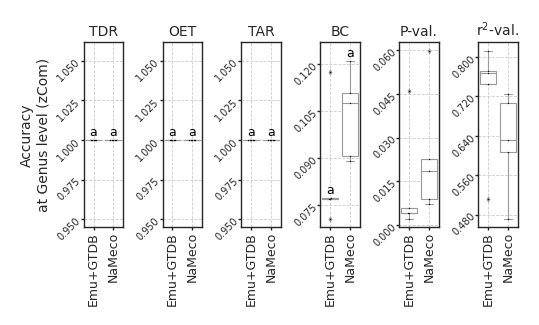

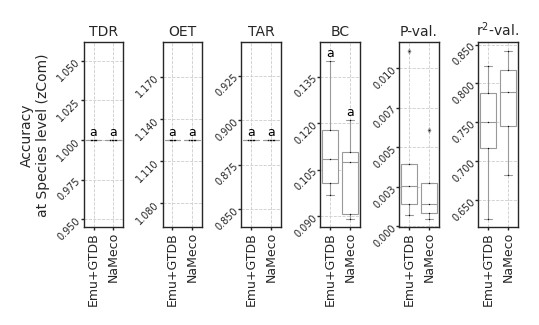

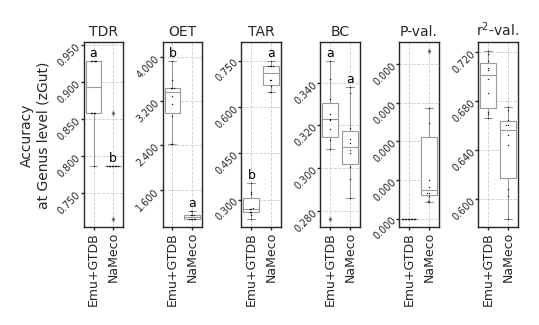

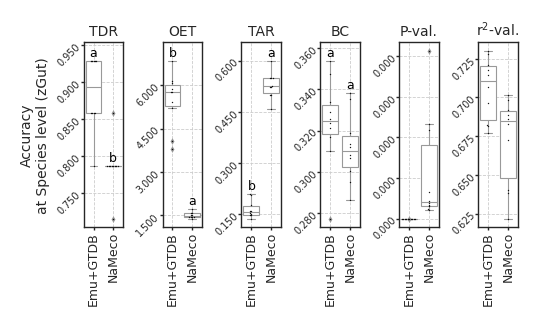

In [169]:
#plot

levs = {
    'Genus': 6,
    'Species': 7,}

renames = {
    'Observed / Expected Taxa': 'OET',
    'TAR': 'TAR', 
    'TDR': 'TDR',
    'P value': 'P_value',
    'Std Err': 'StdErr',
    'Bray-Curtis': 'Bray_Curtis',
    'r-squared': 'r_squared',}

SUBS = {
    'TDR': ['TDR', 'descending'], 
    'Observed / Expected Taxa': ["OET", 'ascending'], 
    'TAR': ['TAR', 'descending'], 
    'Bray-Curtis': ['BC', 'ascending'],
    'P value': ['P-val.'], 
    'r-squared': ['r$^2$-val.']}

for std in STDS:
    ACC = f'Results/Tools/Accuracy/Emu_GTDB_NaMeco/{std}'

    pairs = pd.read_csv(f'{ACC}/anova_pairs.tsv', sep='\t')
    pairs[['Group1', 'Group2']] = pairs['Unnamed: 0'].str.split('-', expand=True)
    ress = pd.read_csv(f"{ACC}/ress_accuracy.tsv", sep='\t', index_col='sample')
    
    #set figure
    rows, cols = 1, len(SUBS)
    
    for lev, l in levs.items():
        #figure
        fig, axes = plt.subplots(rows, cols, figsize=(2.8, 1.2), sharey=False,
                    gridspec_kw={'wspace': 1})
        #axs, i = [[r, c] for r in range(rows) for c in range(cols)], 0
        
        for i, fact in enumerate(SUBS):
            data = ress.loc[(ress.level == l)].copy()
            data = data[(data[fact].notna())]
    
            ### Boxplots ###
            #ax, i = axes[axs[i][0]][axs[i][1]], i+1
            ax = axes[i]
            sns.boxplot(y=fact, x='Tool', data=data, ax=ax, linewidth=0.4, fliersize=0.3, 
                        order=tools, color='white', showfliers=True)
            #sns.violinplot(x=fact, y='Tool', data=data, ax=ax, order=order, )
            sns.swarmplot(y=fact, x='Tool', data=data, order=tools, ax=ax, size=.5, 
                          alpha=0.9, legend=False, c='black')
            ax.tick_params(axis='both', labelsize=3.5, length=1, pad=-.5, width=0.5,rotation=45 )
            ax.tick_params(axis='x', labelsize=4.5, rotation=90, pad=.5)
            ax.yaxis.set_major_locator(plt.MaxNLocator(5))
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.3f'))
            #ax.tick_params(axis='y', labelsize=5, rotation=315, va='bottom')
            #ax.set_yticklabels([l.replace('_', '\n(')+')' for l in order])
            ax.set_ylabel('')
            ax.set_xlabel('')
            ax.grid(lw=.3, ls='--')
            if fact == list(SUBS.keys())[0]: 
                ax.set_ylabel(f'Accuracy\nat {lev} level ({std})', fontsize=5, labelpad=2)
            #else:
            #    ax.tick_params(axis='y', labelsize=0, rotation=90, labelcolor='white', pad=-1)
            ax.text(.5, 1.04, SUBS[fact][0], ha='center', fontsize=5, transform=ax.transAxes)
            #[axc.set_linewidth(0.5) for axc in ax.collections]
            
            
            if fact not in ['P value', 'r-squared']:
                #cld
                statsdf = pairs.loc[(pairs.Level == lev) & (pairs.Metric == renames[fact])].copy()
                #display(statsdf)
                cld = cld4py.assign_letters(statsdf, 'Group1', 'Group2', 'pvalue-fdr_bh', 
                      order=SUBS[fact][1], data=data, vals=fact, group='Tool', param=True)
                #display(cld)
                cld4py.plot_letters(cld=cld, data=data, figax=ax, axis='x', plot='boxplot', pos='upper', 
                           vals=fact, group='Tool', pad=1, c='black', fs=4.5, lim=6)
        
        plt.savefig(f'Figures/Accuracy_Emu_GTDB_NaMeco_{std}_{lev}.svg')